## Problem Statement
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.

## Import necessary libraries

In [1]:
#importing libraries 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
from typing import Union

#Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,PowerTransformer

#Modelling
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer

#Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report

import os
from sklearn.impute import SimpleImputer

## Data Understanding

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

In [3]:
print(df_train.shape)
print(df_test.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [4]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [5]:
df_train.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [6]:
df_train.columns

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=172)

In [7]:
df_train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [8]:
df_train.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,7.410000,6.675000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,119.390000,115.837500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


In [9]:
df_train['churn_probability'].value_counts()

0    62867
1     7132
Name: churn_probability, dtype: int64

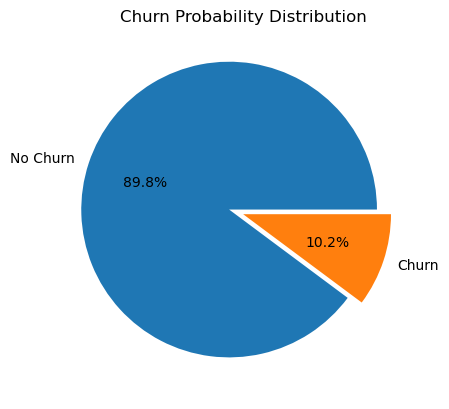

In [10]:
plt.pie(df_train['churn_probability'].value_counts(),labels=["No Churn","Churn"],explode=[0.1,0 ],autopct='%1.1f%%')
plt.title("Churn Probability Distribution")
plt.show()

## Data Cleaning and Preprocessing

In [11]:
percent_null = df_train.isnull().sum().sum() / np.product(df_train.shape) * 100
percent_null

15.241795813029887

In [12]:
df_train_copy = df_train.copy()
df_train_copy["Churn"] = df_train_copy["churn_probability"].apply(lambda x: "Yes" if x == 1 else "No")

In [13]:
colls = []
for col in df_train.columns:
    null_col = df_train[col].isnull().sum() / df_train.shape[0] * 100
    if null_col>30:
        colls+=[col]
    print("{} : {:.2f}".format(col,null_col))

id : 0.00
circle_id : 0.00
loc_og_t2o_mou : 1.00
std_og_t2o_mou : 1.00
loc_ic_t2o_mou : 1.00
last_date_of_month_6 : 0.00
last_date_of_month_7 : 0.57
last_date_of_month_8 : 1.05
arpu_6 : 0.00
arpu_7 : 0.00
arpu_8 : 0.00
onnet_mou_6 : 3.95
onnet_mou_7 : 3.84
onnet_mou_8 : 5.29
offnet_mou_6 : 3.95
offnet_mou_7 : 3.84
offnet_mou_8 : 5.29
roam_ic_mou_6 : 3.95
roam_ic_mou_7 : 3.84
roam_ic_mou_8 : 5.29
roam_og_mou_6 : 3.95
roam_og_mou_7 : 3.84
roam_og_mou_8 : 5.29
loc_og_t2t_mou_6 : 3.95
loc_og_t2t_mou_7 : 3.84
loc_og_t2t_mou_8 : 5.29
loc_og_t2m_mou_6 : 3.95
loc_og_t2m_mou_7 : 3.84
loc_og_t2m_mou_8 : 5.29
loc_og_t2f_mou_6 : 3.95
loc_og_t2f_mou_7 : 3.84
loc_og_t2f_mou_8 : 5.29
loc_og_t2c_mou_6 : 3.95
loc_og_t2c_mou_7 : 3.84
loc_og_t2c_mou_8 : 5.29
loc_og_mou_6 : 3.95
loc_og_mou_7 : 3.84
loc_og_mou_8 : 5.29
std_og_t2t_mou_6 : 3.95
std_og_t2t_mou_7 : 3.84
std_og_t2t_mou_8 : 5.29
std_og_t2m_mou_6 : 3.95
std_og_t2m_mou_7 : 3.84
std_og_t2m_mou_8 : 5.29
std_og_t2f_mou_6 : 3.95
std_og_t2f_mou_7 : 3.8

In [14]:
colls

['date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']

In [15]:
df_train = df_train.drop(colls,axis=1)

In [16]:
df_train.isnull().sum().sum()

273616

In [17]:
colls = []
for col in df_train.columns:
    if df_train[col].dtype == object:
        colls+=[col]
        print(col)

last_date_of_month_6
last_date_of_month_7
last_date_of_month_8
date_of_last_rech_6
date_of_last_rech_7
date_of_last_rech_8


In [18]:
df_train[colls]

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
0,6/30/2014,7/31/2014,8/31/2014,6/22/2014,7/10/2014,8/24/2014
1,6/30/2014,7/31/2014,8/31/2014,6/12/2014,7/10/2014,8/26/2014
2,6/30/2014,7/31/2014,8/31/2014,6/11/2014,7/22/2014,8/24/2014
3,6/30/2014,7/31/2014,8/31/2014,6/15/2014,7/21/2014,8/25/2014
4,6/30/2014,7/31/2014,8/31/2014,6/25/2014,7/26/2014,8/30/2014
...,...,...,...,...,...,...
69994,6/30/2014,7/31/2014,8/31/2014,6/18/2014,7/31/2014,8/31/2014
69995,6/30/2014,7/31/2014,8/31/2014,6/28/2014,7/31/2014,8/27/2014
69996,6/30/2014,7/31/2014,8/31/2014,6/25/2014,7/30/2014,8/29/2014
69997,6/30/2014,7/31/2014,8/31/2014,6/29/2014,7/19/2014,8/26/2014


In [19]:
df_train = df_train.drop(colls,axis=1)

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 136 entries, id to churn_probability
dtypes: float64(108), int64(28)
memory usage: 72.6 MB


In [21]:
colls = []
for col in df_train.columns:
    if df_train[col].nunique() ==1:
        colls+=[col]
    print('{} : {}'.format(col,df_train[col].nunique()))

id : 69999
circle_id : 1
loc_og_t2o_mou : 1
std_og_t2o_mou : 1
loc_ic_t2o_mou : 1
arpu_6 : 61615
arpu_7 : 61425
arpu_8 : 60194
onnet_mou_6 : 20057
onnet_mou_7 : 20076
onnet_mou_8 : 19725
offnet_mou_6 : 26254
offnet_mou_7 : 26139
offnet_mou_8 : 25995
roam_ic_mou_6 : 5306
roam_ic_mou_7 : 4240
roam_ic_mou_8 : 4252
roam_og_mou_6 : 6568
roam_og_mou_7 : 5305
roam_og_mou_8 : 5215
loc_og_t2t_mou_6 : 11491
loc_og_t2t_mou_7 : 11359
loc_og_t2t_mou_8 : 11296
loc_og_t2m_mou_6 : 17848
loc_og_t2m_mou_7 : 17641
loc_og_t2m_mou_8 : 17616
loc_og_t2f_mou_6 : 3376
loc_og_t2f_mou_7 : 3365
loc_og_t2f_mou_8 : 3311
loc_og_t2c_mou_6 : 1945
loc_og_t2c_mou_7 : 2103
loc_og_t2c_mou_8 : 2204
loc_og_mou_6 : 22309
loc_og_mou_7 : 22012
loc_og_mou_8 : 21950
std_og_t2t_mou_6 : 14554
std_og_t2t_mou_7 : 14745
std_og_t2t_mou_8 : 14483
std_og_t2m_mou_6 : 16059
std_og_t2m_mou_7 : 16234
std_og_t2m_mou_8 : 15968
std_og_t2f_mou_6 : 2074
std_og_t2f_mou_7 : 1991
std_og_t2f_mou_8 : 1945
std_og_t2c_mou_6 : 1
std_og_t2c_mou_7 : 1
std

In [22]:
df_train[colls]

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8
0,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
69994,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69995,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df_train = df_train.drop(colls,axis=1)

In [24]:
df_train.shape

(69999, 126)

In [25]:
df_train.fillna(0,inplace=True)

In [26]:
df_train.drop('id',inplace=True,axis=1)

# EDA

- Univariate Analysis

In [27]:
colls = []
for col in df_train.columns:
    if df_train[col].nunique() <20:
        colls+=[col]
        print('{} : {}'.format(col,df_train[col].nunique()))

monthly_2g_6 : 5
monthly_2g_7 : 6
monthly_2g_8 : 6
monthly_3g_6 : 10
monthly_3g_7 : 13
monthly_3g_8 : 12
churn_probability : 2


In [28]:
def category_counts(col):
    plt.figure(figsize=(12,8));
    sns.countplot(x=df_train[col],palette='RdYlGn');
    plt.xlabel(col);
    plt.ylabel('Counts');
    plt.title(f"{col} Value Counts");
    plt.show()

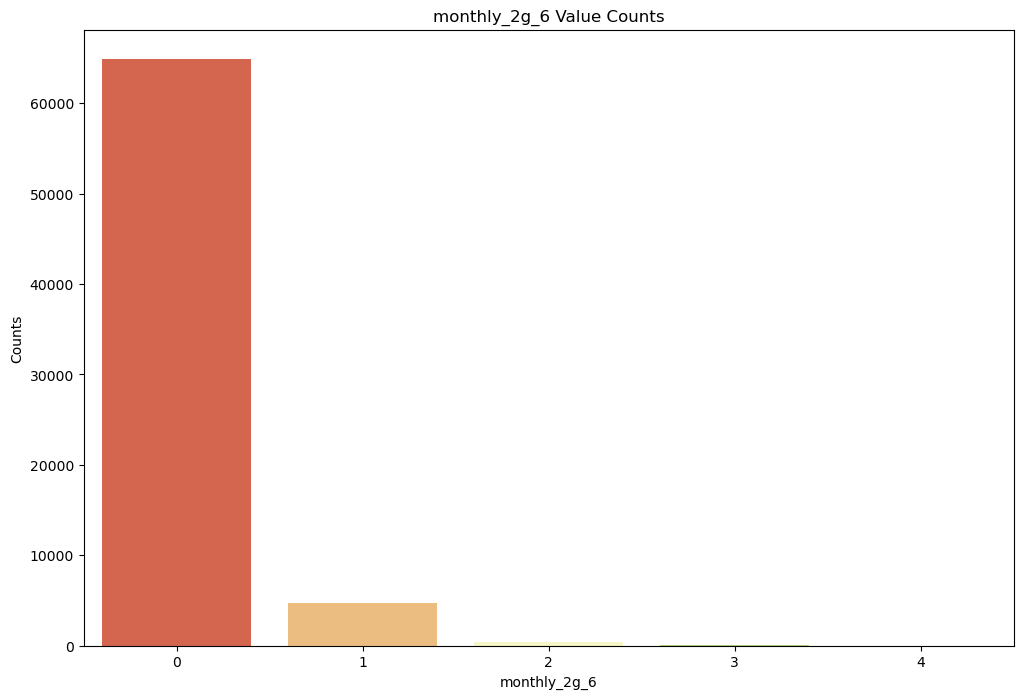

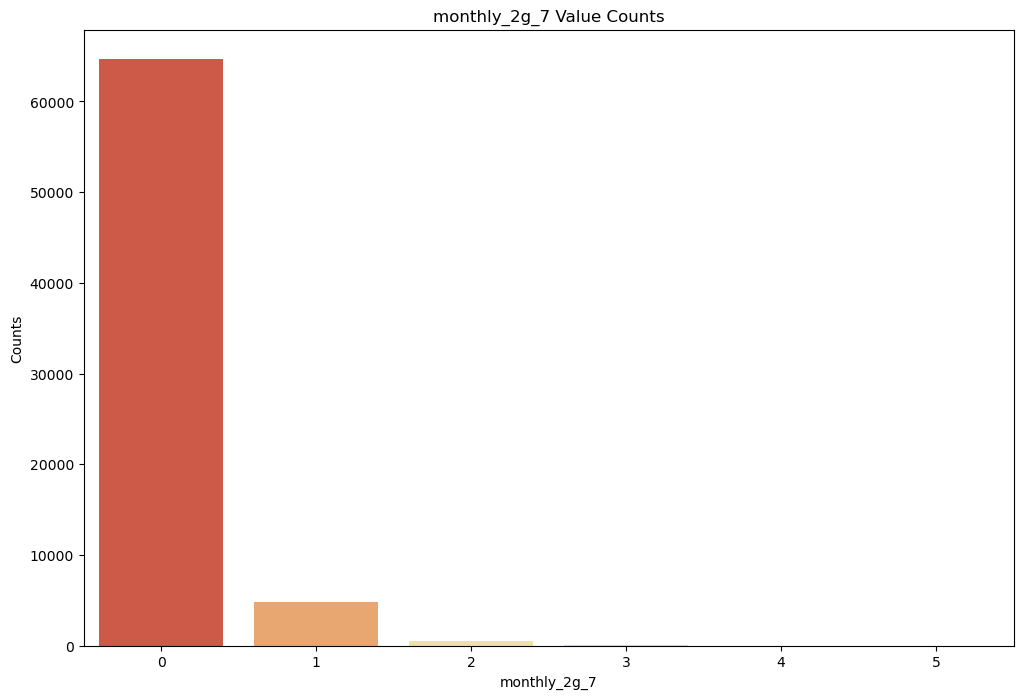

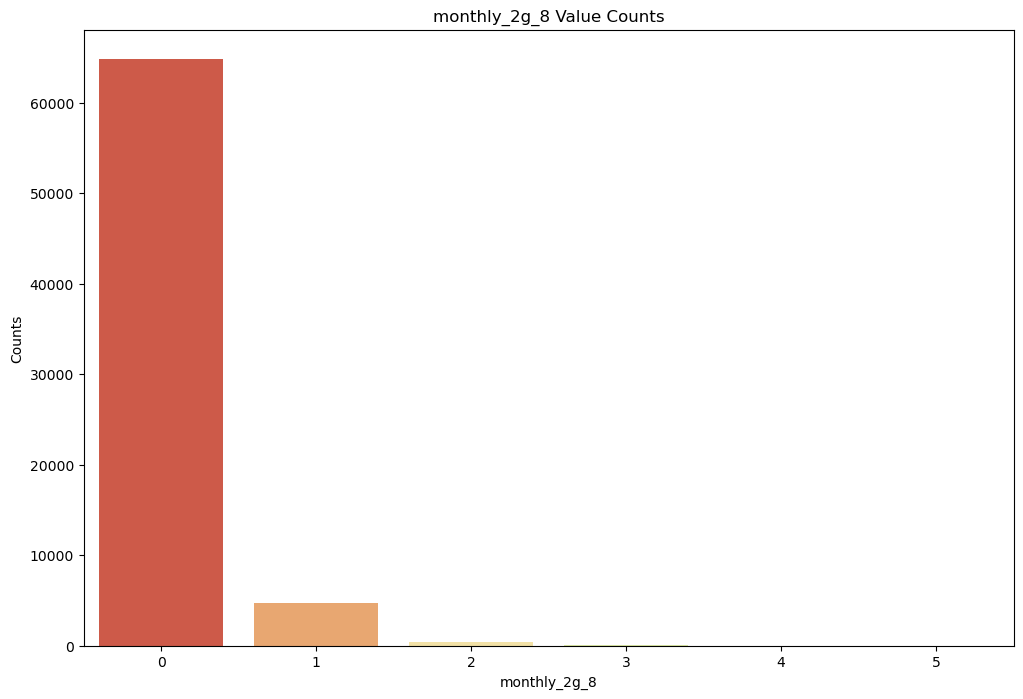

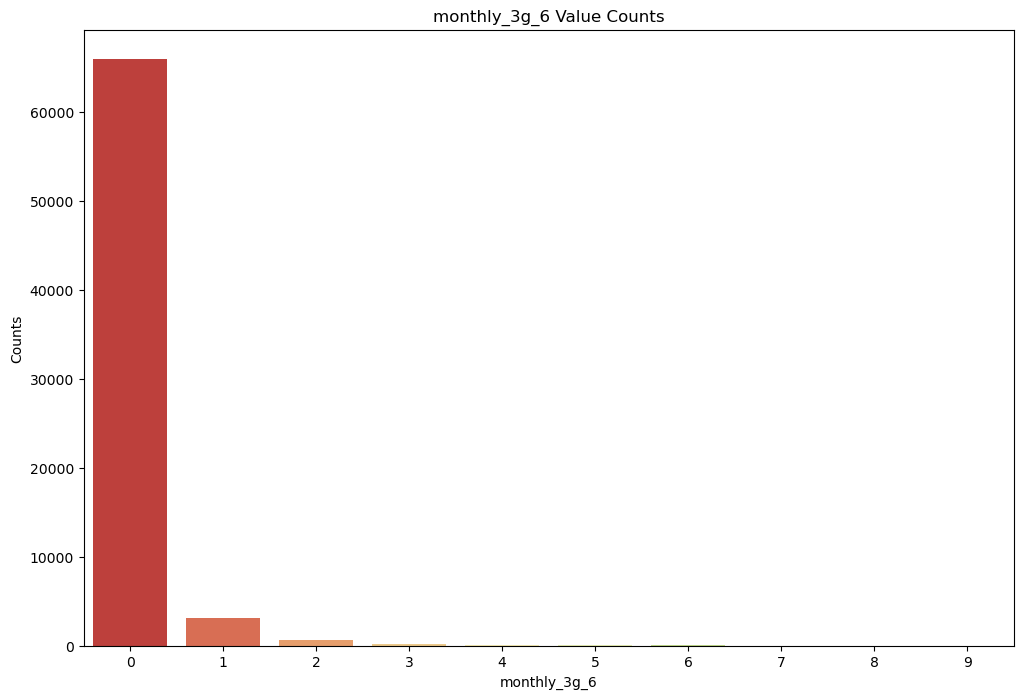

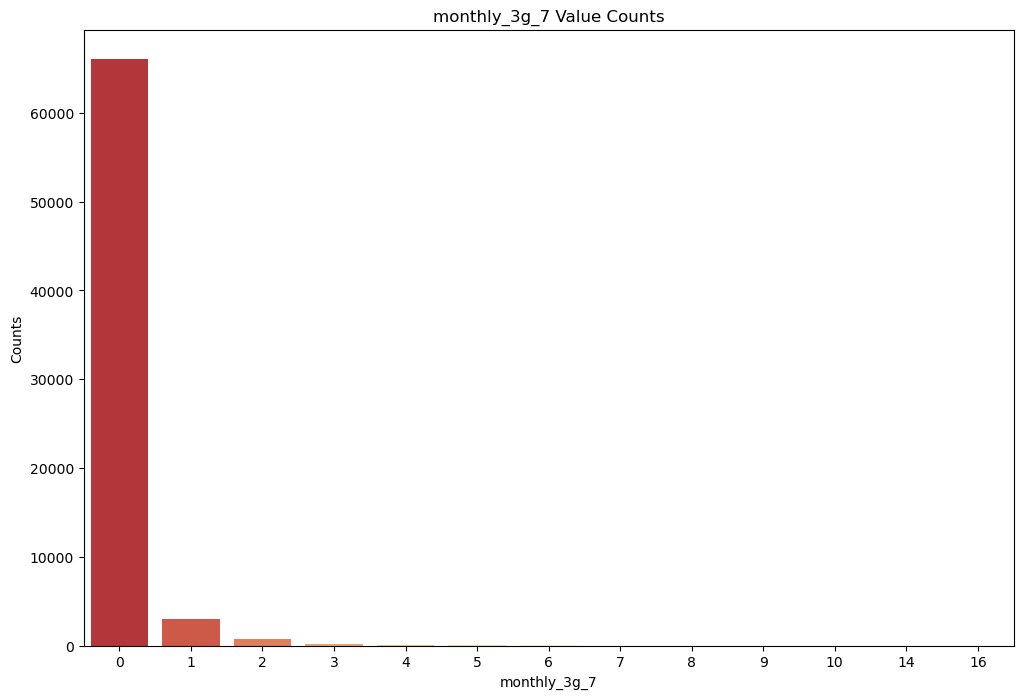

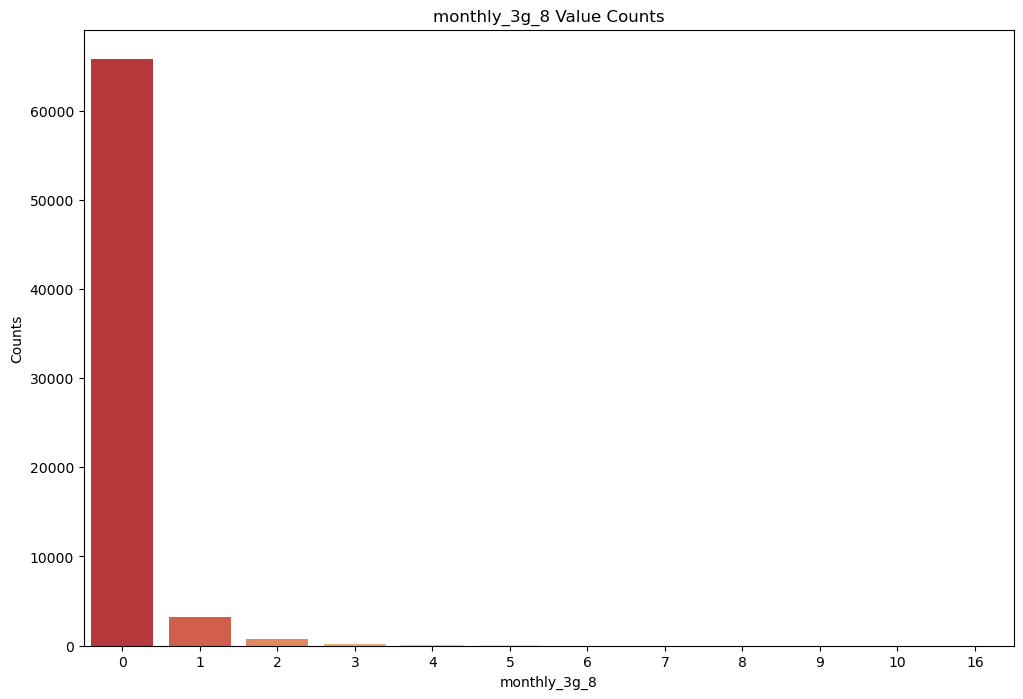

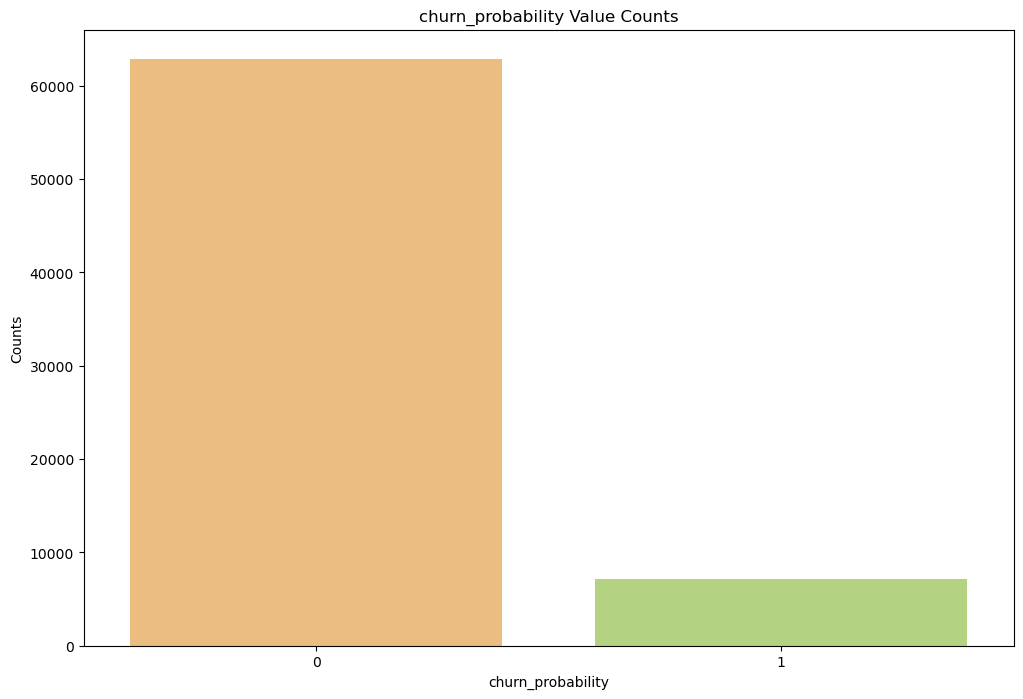

In [29]:
# checking for 2g and 3g users for june, july and august.
for col in colls:
    category_counts(col)

In [30]:
df_train_copy['tenure'] = (df_train_copy['aon']/30).round(0)
# df_train_copy.drop('aon',axis=1, inplace=True)

C:\Users\AnkitSukantaKumarGay\AppData\Local\Temp\ipykernel_8660\3701572117.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train_copy['tenure'],bins=30)


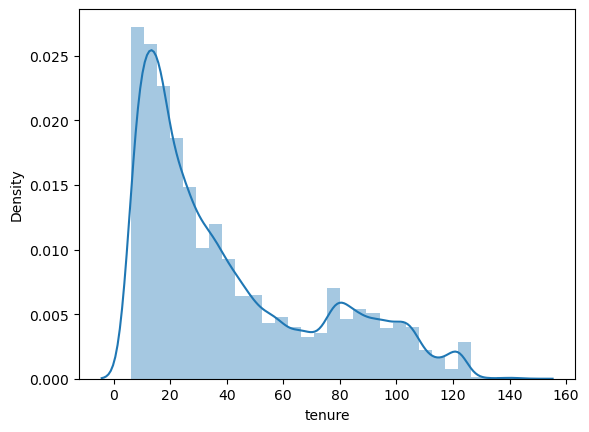

In [31]:
# Checking the distribution of he tenure variable
sns.distplot(df_train_copy['tenure'],bins=30)
plt.show()

- Bivariate Analysis

In [32]:
fb_user = ["fb_user_6", "fb_user_7", "fb_user_8"]

for col in fb_user:
    df_train_copy[f"Category_{col}"] = df_train_copy[col].apply(lambda x: "Yes" if x == 1 else "No")

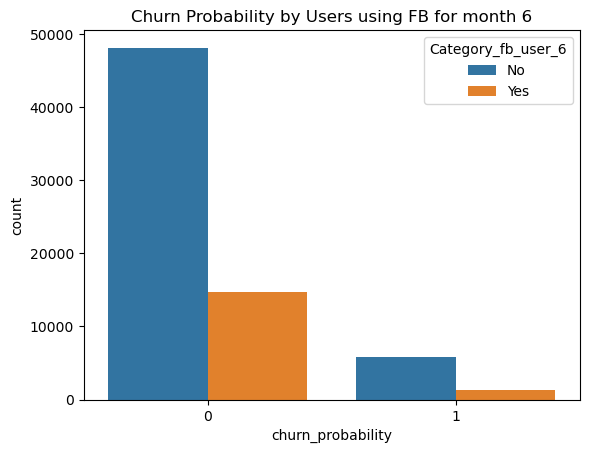

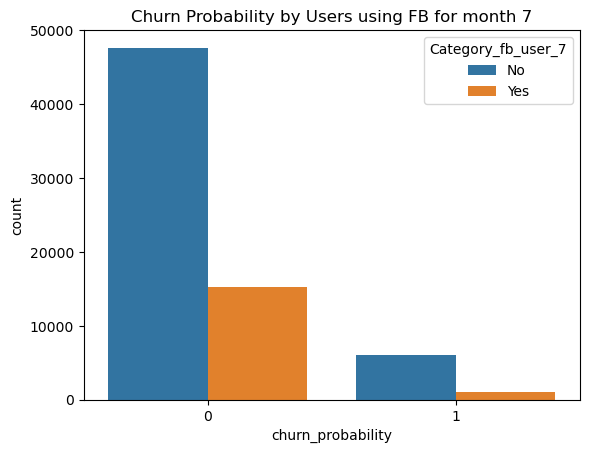

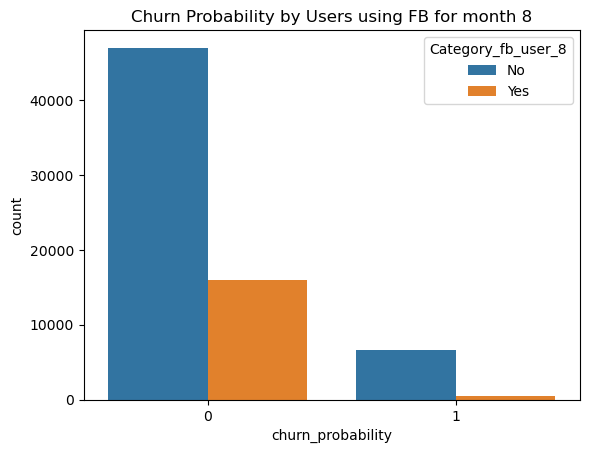

In [33]:
# Churn probability of fb users
fb_user = ["Category_fb_user_6", "Category_fb_user_7", "Category_fb_user_8"]

for col in fb_user:
    sns.countplot(x='churn_probability', hue=col, data=df_train_copy)
    plt.title(f'Churn Probability by Users using FB for month {col[-1]}')
    plt.show()

- People uses facebook have less probability of churning

In [34]:
night_user = ["night_pck_user_6", "night_pck_user_7", "night_pck_user_8"]

for col in night_user:
    df_train_copy[f"Category_{col}"] = df_train_copy[col].apply(lambda x: "Yes" if x == 1 else "No")

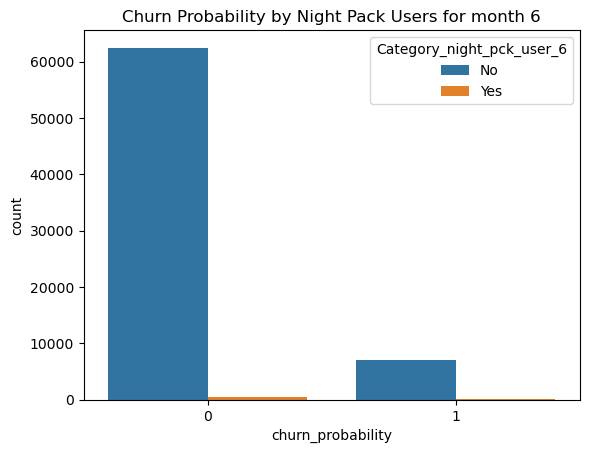

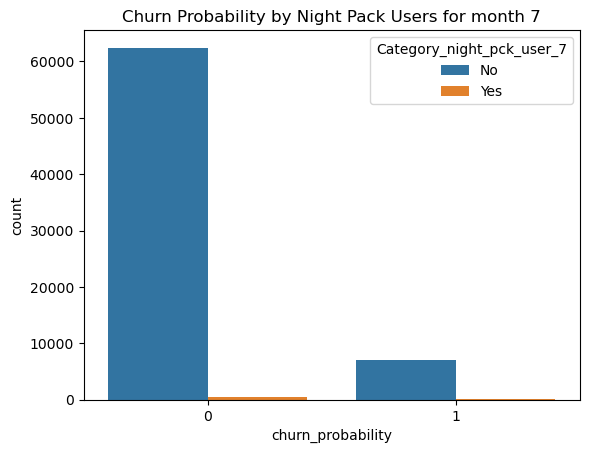

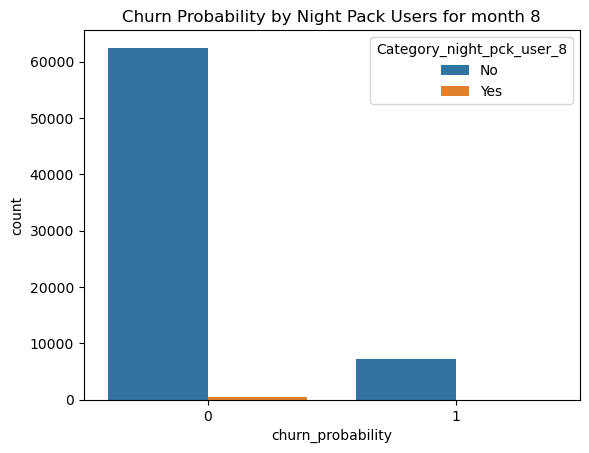

In [35]:
# Churn probability of night pack users
night_user = ["Category_night_pck_user_6", "Category_night_pck_user_7", "Category_night_pck_user_8"]

for col in night_user:
    sns.countplot(x='churn_probability', hue=col, data=df_train_copy)
    plt.title(f'Churn Probability by Night Pack Users for month {col[-1]}')
    plt.show()

- People have very less probability of churning either a night pack user or not

In [36]:
bins = [0, 90, 180, 270, 365, 730, 1095, 1460, 1825, float('inf')]
labels = [
    '0-3 months', 
    '3-6 months', 
    '6-9 months', 
    '9 months - 1 year', 
    '1-2 years', 
    '2-3 years', 
    '3-4 years', 
    '4-5 years', 
    '5+ years'
]

# Categorize the AON column
df_train_copy['tenure1'] = pd.cut(df_train_copy['aon'], bins=bins, labels=labels, right=False)

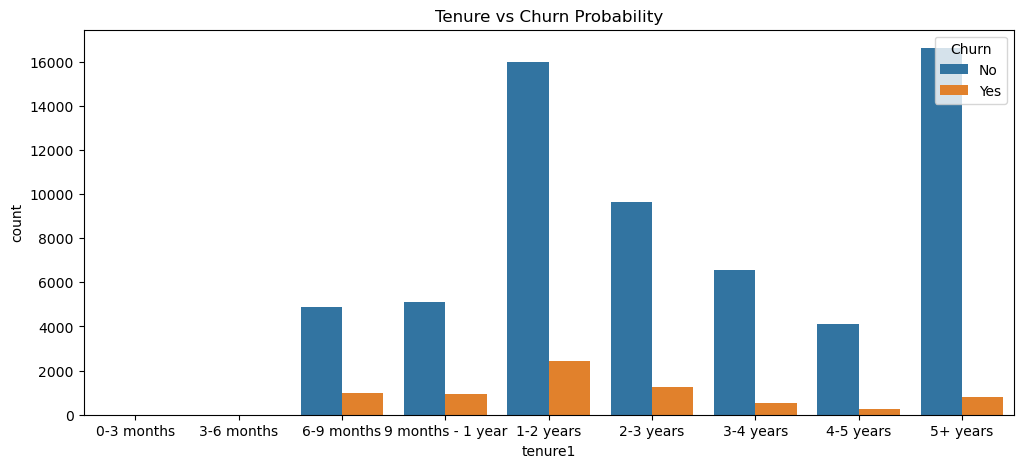

In [37]:
plt.figure(figsize=[12, 5])
sns.countplot(x='tenure1', hue="Churn", data=df_train_copy)
plt.title(f'Tenure vs Churn Probability')
plt.show()

- It can be seen that the maximum churn rate happens within 6 month to 2 years, but it gradually decreases as the customer retains in the network.

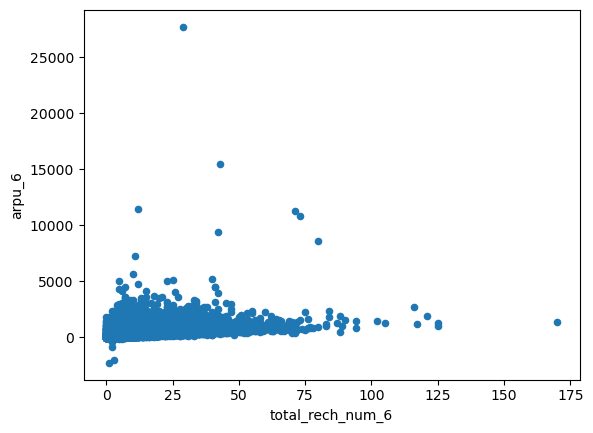

In [38]:
# Average revenue vs total recharges for june
df_train_copy[['total_rech_num_6', 'arpu_6']].plot.scatter(x = 'total_rech_num_6',
                                                              y='arpu_6')
plt.show()

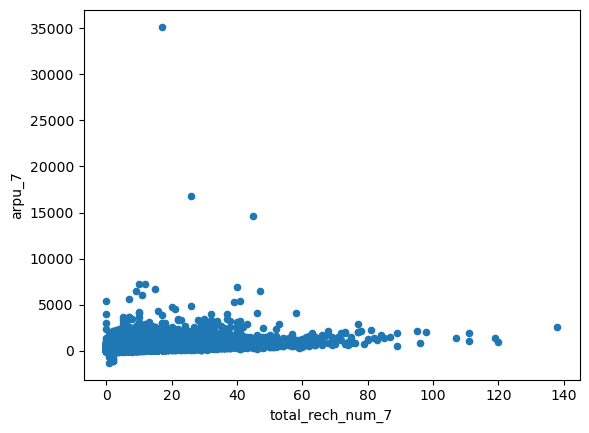

In [39]:
# Average revenue vs total recharges for july
df_train_copy[['total_rech_num_7', 'arpu_7']].plot.scatter(x = 'total_rech_num_7',
                                                              y='arpu_7')
plt.show()

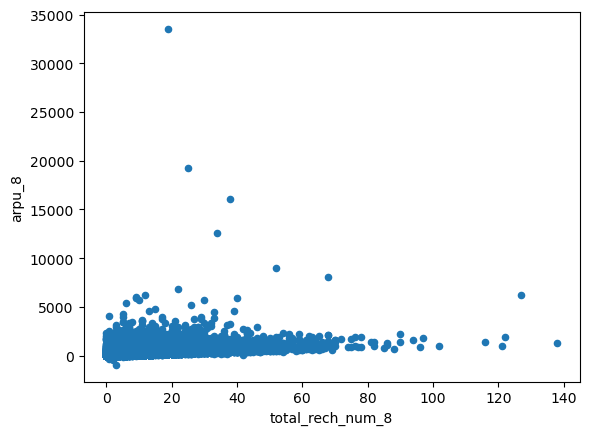

In [40]:
# Average revenue vs total recharges for august
df_train_copy[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8',
                                                              y='arpu_8')
plt.show()

- Little more revenue in the month of june tahn other months

In [41]:
# Creating categories for month 8 column totalrecharge and their count
df_train_copy['total_rech_data_group_8']=pd.cut(df_train_copy['total_rech_amt_8'],[-1,0,10,25,100],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
df_train_copy['total_rech_num_group_8']=pd.cut(df_train_copy['total_rech_num_8'],[-1,0,10,25,1000],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])

					Distribution of total_rech_data_8 variable
 No_Recharge        9487
>25_Recharges      8399
10-25_Recharges     675
<=10_Recharges      370
Name: total_rech_data_group_8, dtype: int64


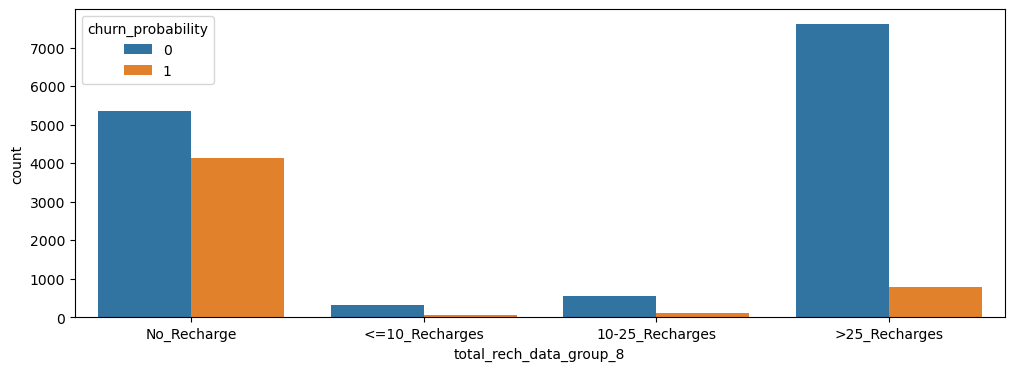

					Distribution of total_rech_num_8 variable
 <=10_Recharges     53312
10-25_Recharges    12266
No_Recharge         2461
>25_Recharges       1960
Name: total_rech_num_group_8, dtype: int64


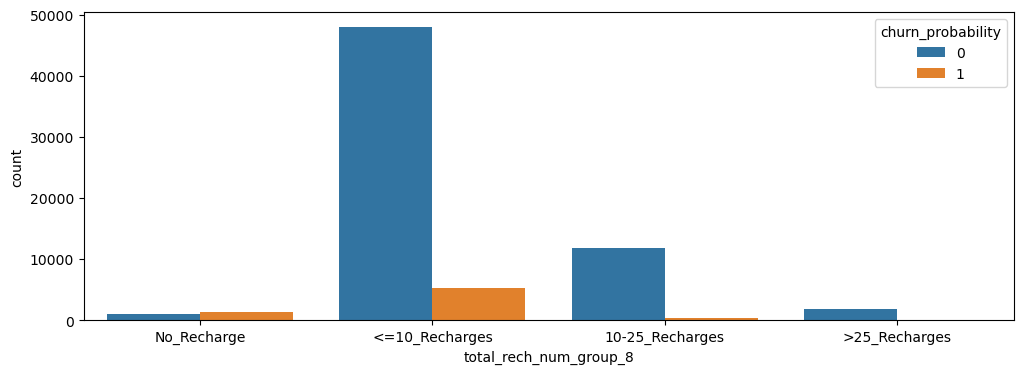

In [42]:
plt.figure(figsize=[12,4])
sns.countplot(data=df_train_copy,x="total_rech_data_group_8",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_data_8 variable\n",df_train_copy['total_rech_data_group_8'].value_counts())
plt.show()
plt.figure(figsize=[12,4])
sns.countplot(data=df_train_copy,x="total_rech_num_group_8",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_num_8 variable\n",df_train_copy['total_rech_num_group_8'].value_counts())
plt.show()

- Multivariate Analysis

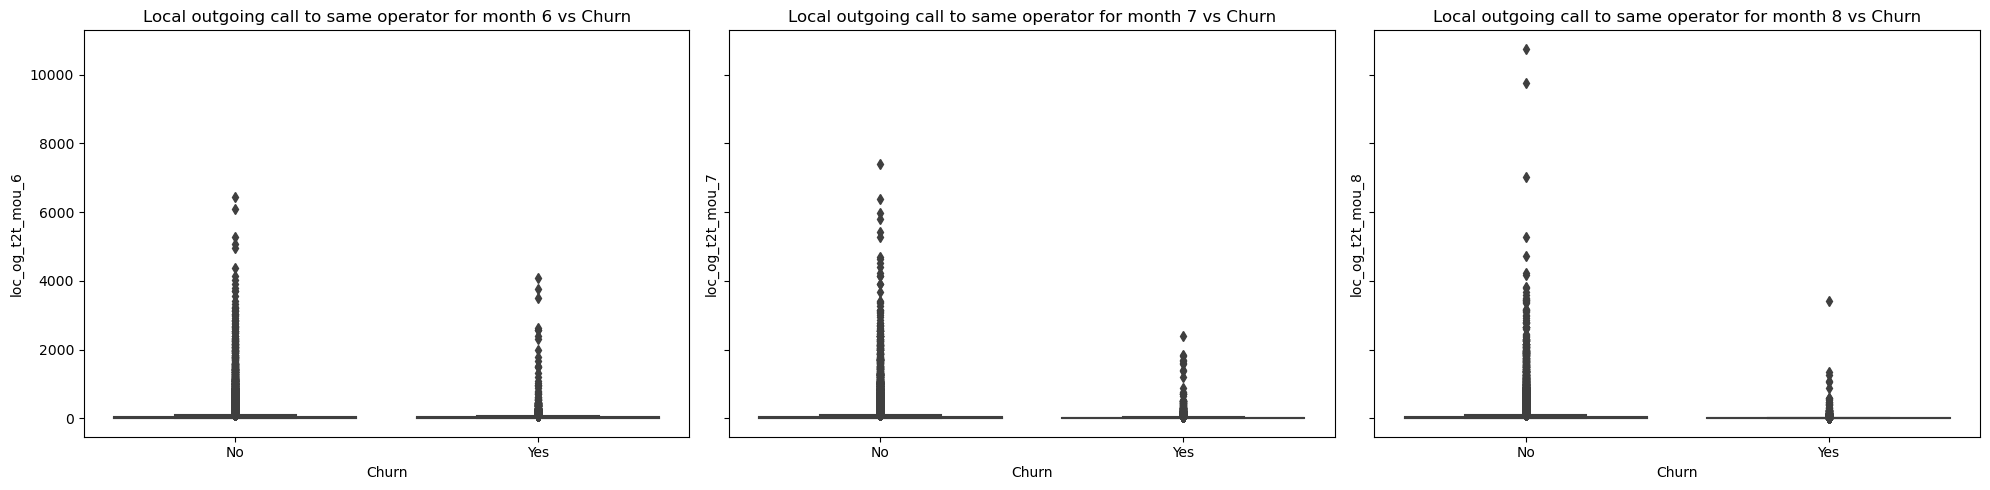

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

sns.boxplot(x='Churn', y='loc_og_t2t_mou_6', data=df_train_copy, ax=axes[0])
axes[0].set_title('Local outgoing call to same operator for month 6 vs Churn')

sns.boxplot(x='Churn', y='loc_og_t2t_mou_7', data=df_train_copy, ax=axes[1])
axes[1].set_title('Local outgoing call to same operator for month 7 vs Churn')

sns.boxplot(x='Churn', y='loc_og_t2t_mou_8', data=df_train_copy, ax=axes[2])
axes[2].set_title('Local outgoing call to same operator for month 8 vs Churn')

plt.tight_layout()
plt.show()

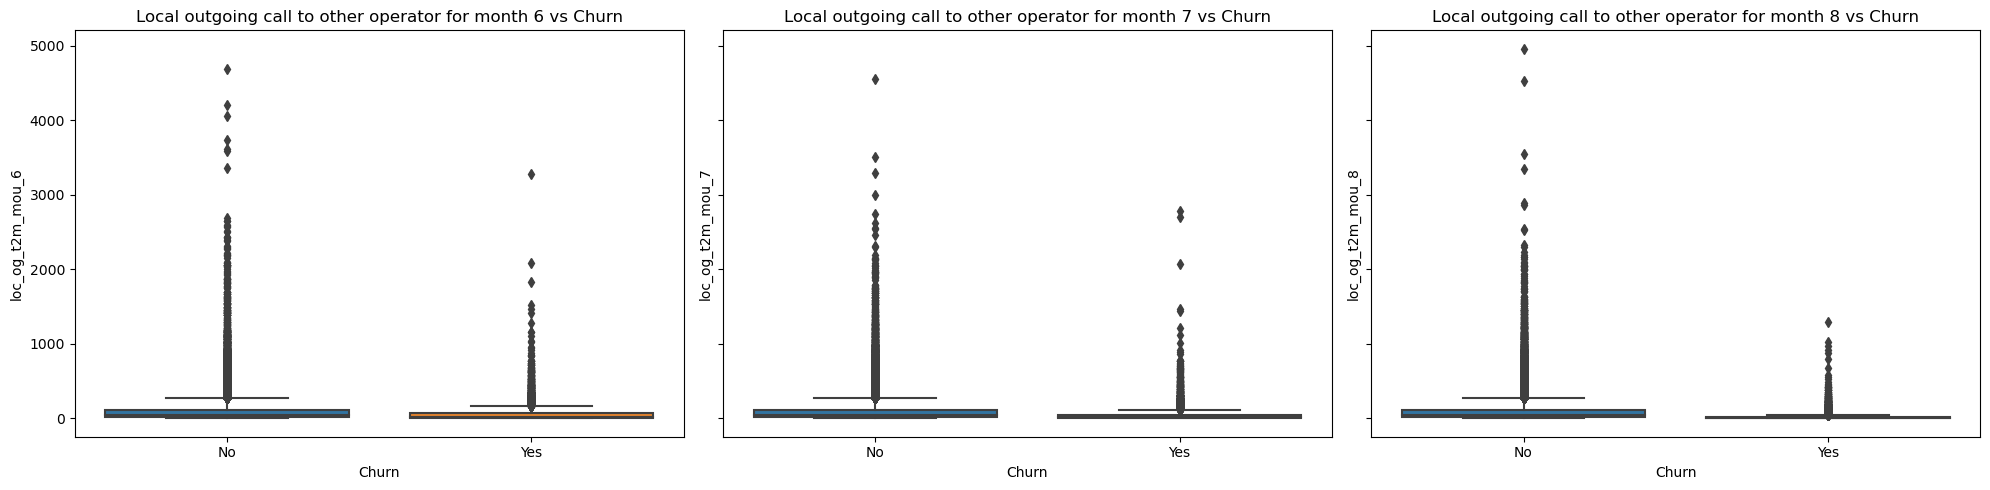

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

sns.boxplot(x='Churn', y='loc_og_t2m_mou_6', data=df_train_copy, ax=axes[0])
axes[0].set_title('Local outgoing call to other operator for month 6 vs Churn')

sns.boxplot(x='Churn', y='loc_og_t2m_mou_7', data=df_train_copy, ax=axes[1])
axes[1].set_title('Local outgoing call to other operator for month 7 vs Churn')

sns.boxplot(x='Churn', y='loc_og_t2m_mou_8', data=df_train_copy, ax=axes[2])
axes[2].set_title('Local outgoing call to other operator for month 8 vs Churn')

plt.tight_layout()
plt.show()

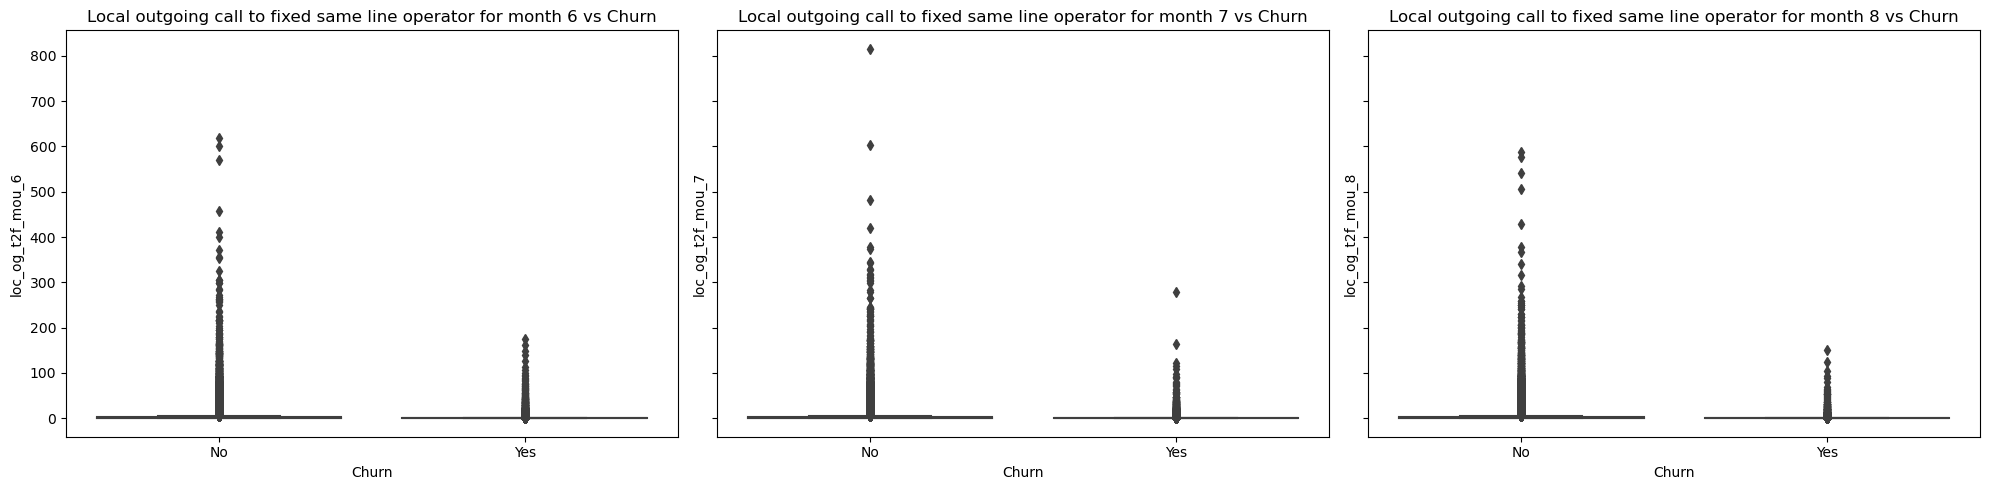

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

sns.boxplot(x='Churn', y='loc_og_t2f_mou_6', data=df_train_copy, ax=axes[0])
axes[0].set_title('Local outgoing call to fixed same line operator for month 6 vs Churn')

sns.boxplot(x='Churn', y='loc_og_t2f_mou_7', data=df_train_copy, ax=axes[1])
axes[1].set_title('Local outgoing call to fixed same line operator for month 7 vs Churn')

sns.boxplot(x='Churn', y='loc_og_t2f_mou_8', data=df_train_copy, ax=axes[2])
axes[2].set_title('Local outgoing call to fixed same line operator for month 8 vs Churn')

plt.tight_layout()
plt.show()

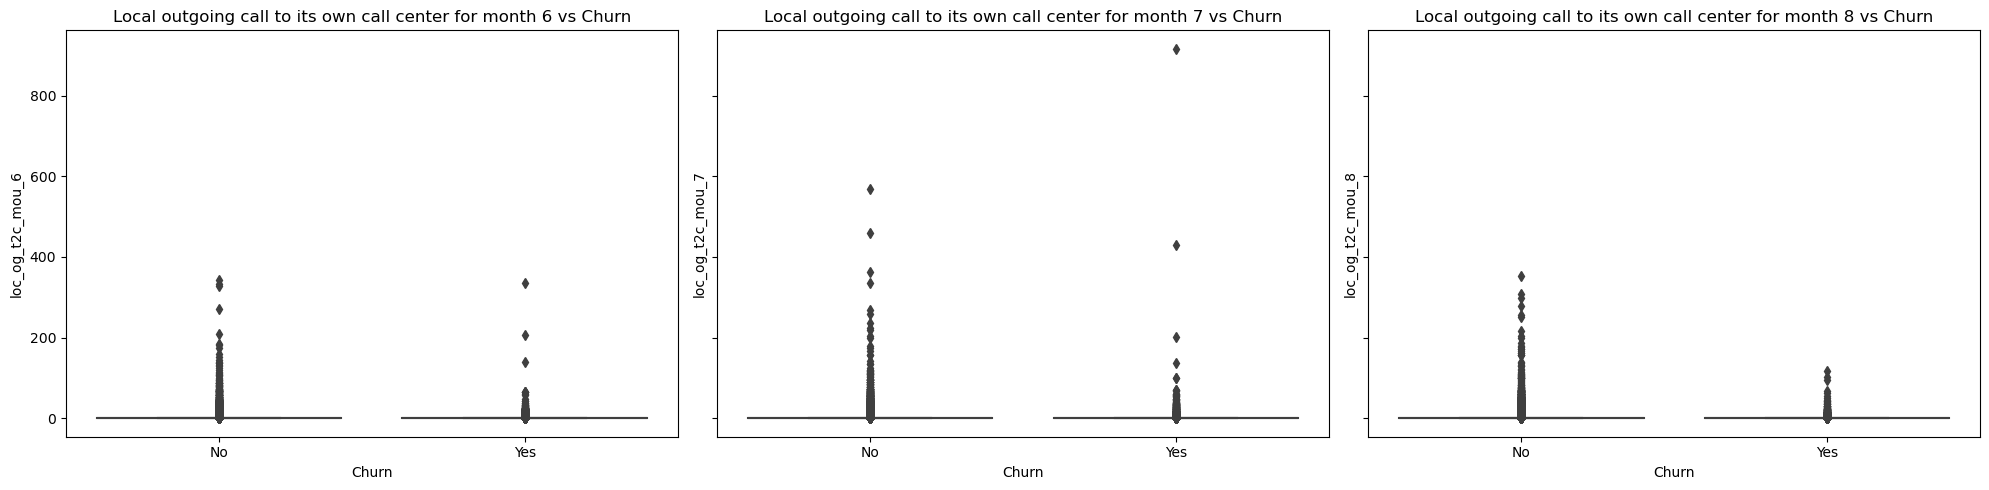

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

sns.boxplot(x='Churn', y='loc_og_t2c_mou_6', data=df_train_copy, ax=axes[0])
axes[0].set_title('Local outgoing call to its own call center for month 6 vs Churn')

sns.boxplot(x='Churn', y='loc_og_t2c_mou_7', data=df_train_copy, ax=axes[1])
axes[1].set_title('Local outgoing call to its own call center for month 7 vs Churn')

sns.boxplot(x='Churn', y='loc_og_t2c_mou_8', data=df_train_copy, ax=axes[2])
axes[2].set_title('Local outgoing call to its own call center for month 8 vs Churn')

plt.tight_layout()
plt.show()

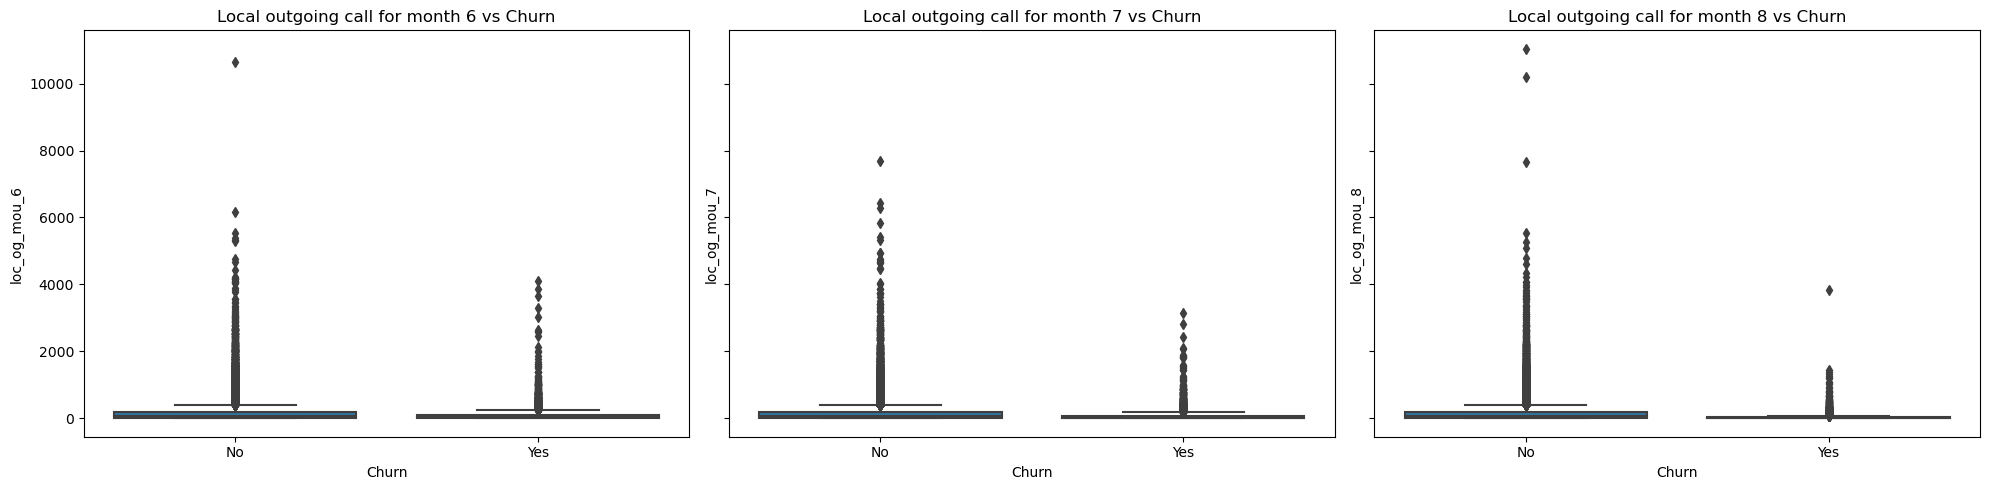

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

sns.boxplot(x='Churn', y='loc_og_mou_6', data=df_train_copy, ax=axes[0])
axes[0].set_title('Local outgoing call for month 6 vs Churn')

sns.boxplot(x='Churn', y='loc_og_mou_7', data=df_train_copy, ax=axes[1])
axes[1].set_title('Local outgoing call for month 7 vs Churn')

sns.boxplot(x='Churn', y='loc_og_mou_8', data=df_train_copy, ax=axes[2])
axes[2].set_title('Local outgoing call for month 8 vs Churn')

plt.tight_layout()
plt.show()

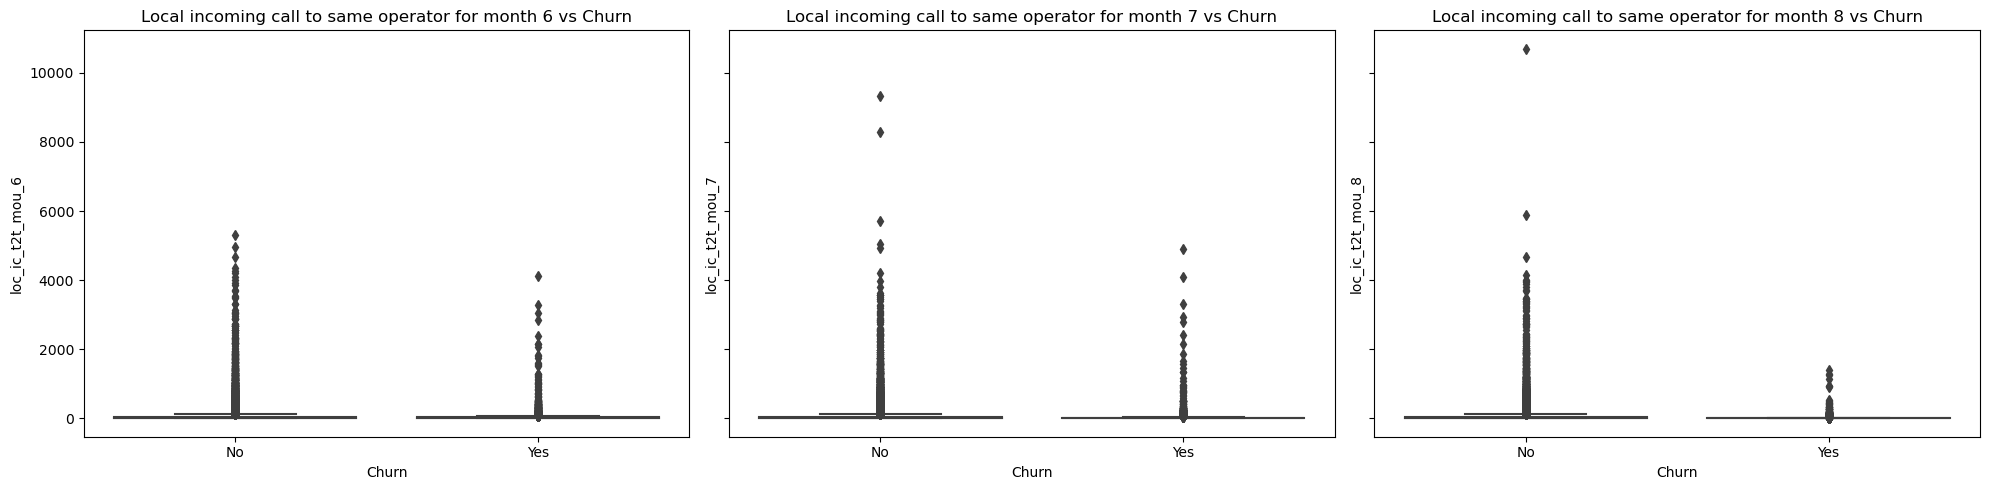

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

sns.boxplot(x='Churn', y='loc_ic_t2t_mou_6', data=df_train_copy, ax=axes[0])
axes[0].set_title('Local incoming call to same operator for month 6 vs Churn')

sns.boxplot(x='Churn', y='loc_ic_t2t_mou_7', data=df_train_copy, ax=axes[1])
axes[1].set_title('Local incoming call to same operator for month 7 vs Churn')

sns.boxplot(x='Churn', y='loc_ic_t2t_mou_8', data=df_train_copy, ax=axes[2])
axes[2].set_title('Local incoming call to same operator for month 8 vs Churn')

plt.tight_layout()
plt.show()

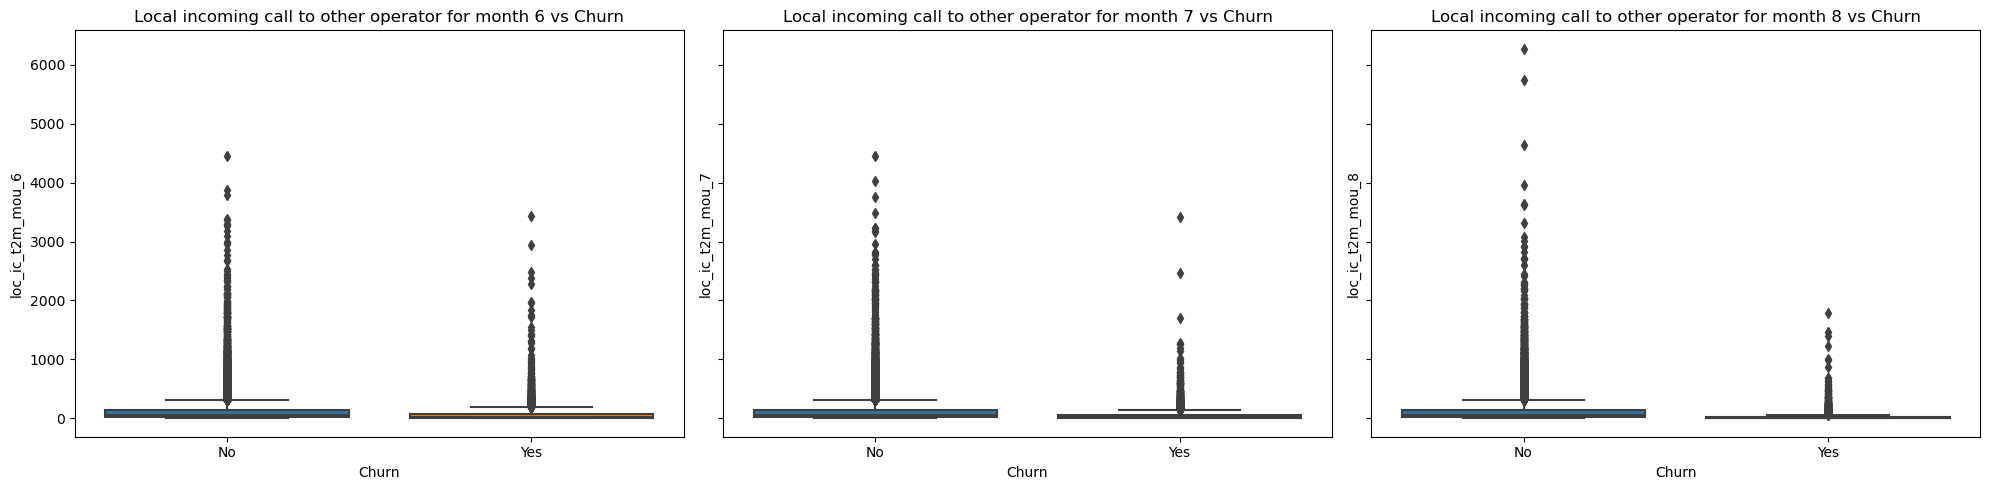

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

sns.boxplot(x='Churn', y='loc_ic_t2m_mou_6', data=df_train_copy, ax=axes[0])
axes[0].set_title('Local incoming call to other operator for month 6 vs Churn')

sns.boxplot(x='Churn', y='loc_ic_t2m_mou_7', data=df_train_copy, ax=axes[1])
axes[1].set_title('Local incoming call to other operator for month 7 vs Churn')

sns.boxplot(x='Churn', y='loc_ic_t2m_mou_8', data=df_train_copy, ax=axes[2])
axes[2].set_title('Local incoming call to other operator for month 8 vs Churn')

plt.tight_layout()
plt.show()

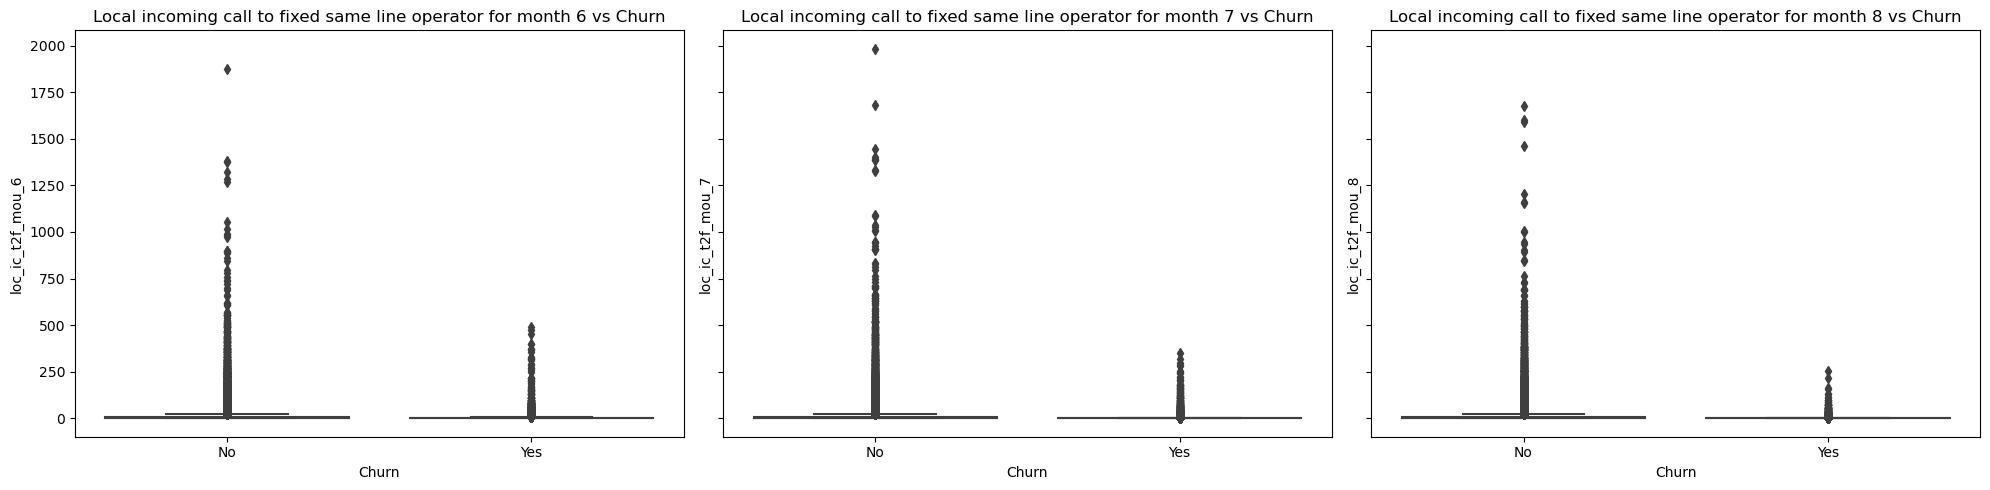

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

sns.boxplot(x='Churn', y='loc_ic_t2f_mou_6', data=df_train_copy, ax=axes[0])
axes[0].set_title('Local incoming call to fixed same line operator for month 6 vs Churn')

sns.boxplot(x='Churn', y='loc_ic_t2f_mou_7', data=df_train_copy, ax=axes[1])
axes[1].set_title('Local incoming call to fixed same line operator for month 7 vs Churn')

sns.boxplot(x='Churn', y='loc_ic_t2f_mou_8', data=df_train_copy, ax=axes[2])
axes[2].set_title('Local incoming call to fixed same line operator for month 8 vs Churn')

plt.tight_layout()
plt.show()

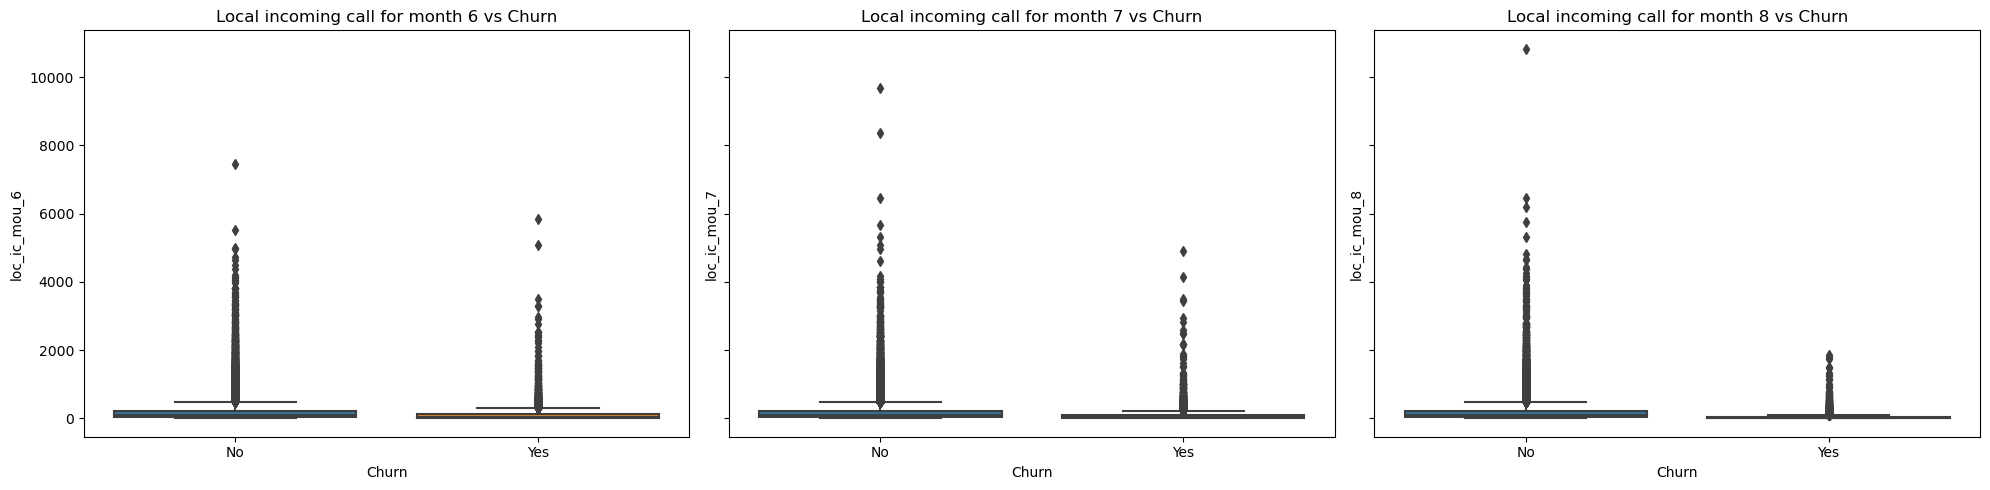

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

sns.boxplot(x='Churn', y='loc_ic_mou_6', data=df_train_copy, ax=axes[0])
axes[0].set_title('Local incoming call for month 6 vs Churn')

sns.boxplot(x='Churn', y='loc_ic_mou_7', data=df_train_copy, ax=axes[1])
axes[1].set_title('Local incoming call for month 7 vs Churn')

sns.boxplot(x='Churn', y='loc_ic_mou_8', data=df_train_copy, ax=axes[2])
axes[2].set_title('Local incoming call for month 8 vs Churn')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Features Correlating with Churn variable')

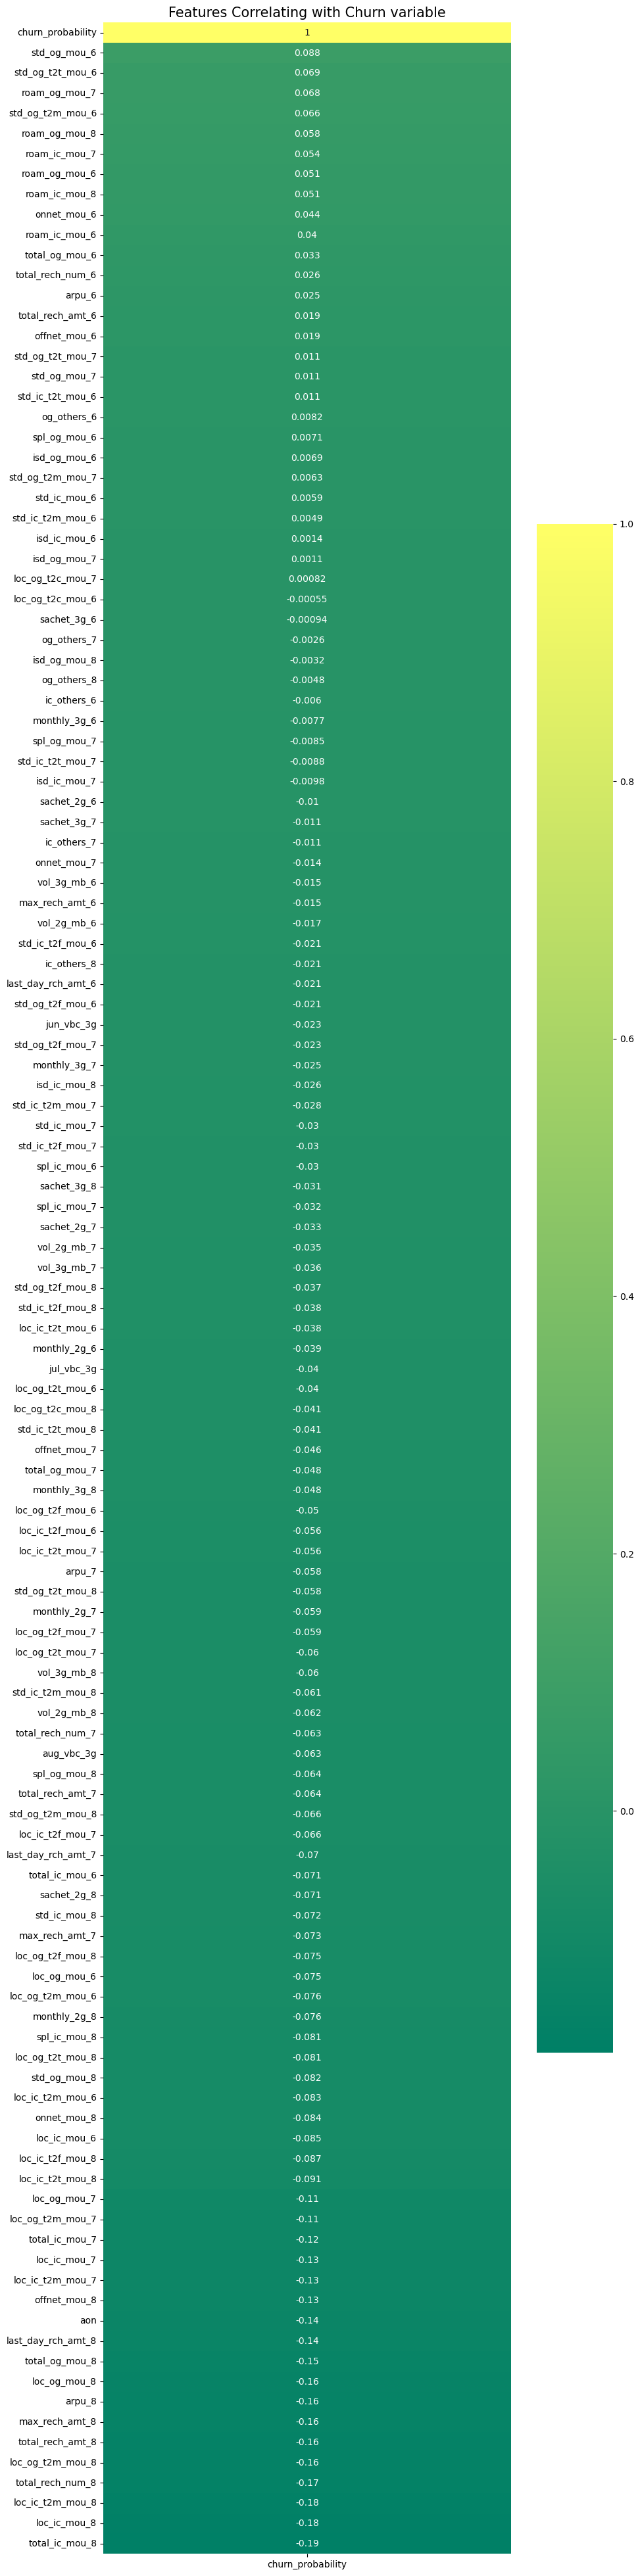

In [52]:
# Checking Correlation between target variable with the other variable in the datase
plt.figure(figsize=(10,50))
heatmap_churn = sns.heatmap(df_train.corr()[['churn_probability']].sort_values(ascending=False, by='churn_probability'),annot=True, 
                                cmap='summer')
heatmap_churn.set_title("Features Correlating with Churn variable", fontsize=15)

In [53]:
#ids = ['id','circle_id']
total_arpu_amounts = [i for i in list(df_train.columns) if re.search('arpu',i)]
total_amounts = [i for i in list(df_train.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(df_train.columns) if re.search('total.+og.+mou',i)]
onnetwork_minutes = [i for i in list(df_train.columns) if re.search('onnet',i)]
ic_roaming_usage = [i for i in list(df_train.columns) if re.search('roam.+ic',i)]
og_roaming_usage = [i for i in list(df_train.columns) if re.search('roam.+og',i)]
postpaid_user_cost = [i for i in list(df_train.columns) if re.search('.+vbc',i)]
offnetwork_minutes = [i for i in list(df_train.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(df_train.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(df_train.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(df_train.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(df_train.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(df_train.columns) if re.search('aon',i)]

#Storing them in a single flat list
variables = [#*ids, 
             *total_arpu_amounts,
             *ic_roaming_usage,
             *og_roaming_usage,
             *onnetwork_minutes,
             *postpaid_user_cost,
             *total_amounts, 
             *total_outgoing_minutes, 
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             'churn_probability']

In [54]:
new_data = df_train[variables]

In [55]:
def drop_cols(data:pd.DataFrame,cols:Union[list,str]):

    print(f"Number of cols before dropping: {data.shape[1]}")

    data = data.drop(cols,axis=1)

    print(f"Number of cols after dropping: {data.shape[1]}")

    return data

In [56]:
new_data['total_avg_rev_per_user'] = new_data['arpu_6'] + new_data['arpu_7'] + new_data['arpu_8']
new_data = drop_cols(new_data,['arpu_6','arpu_7','arpu_8'])

Number of cols before dropping: 33
Number of cols after dropping: 30


C:\Users\AnkitSukantaKumarGay\AppData\Local\Temp\ipykernel_8660\2566729424.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['total_avg_rev_per_user'] = new_data['arpu_6'] + new_data['arpu_7'] + new_data['arpu_8']


In [57]:
new_data['total_incoming_roaming_min_usage'] = new_data['roam_ic_mou_6'] + new_data['roam_ic_mou_7'] + new_data['roam_ic_mou_8']
new_data = drop_cols(new_data,['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8'])

Number of cols before dropping: 31
Number of cols after dropping: 28


In [58]:
new_data['total_outgoing_roaming_min_usage'] = new_data['roam_og_mou_6'] + new_data['roam_og_mou_7'] + new_data['roam_og_mou_8']
new_data = drop_cols(new_data,['roam_og_mou_6','roam_og_mou_7','roam_og_mou_8'])

Number of cols before dropping: 29
Number of cols after dropping: 26


In [59]:
new_data['same_network_calls_min_usage'] = new_data['onnet_mou_6'] + new_data['onnet_mou_7'] + new_data['onnet_mou_8']
new_data = drop_cols(new_data,['onnet_mou_6','onnet_mou_7','onnet_mou_8'])

Number of cols before dropping: 27
Number of cols after dropping: 24


In [60]:
new_data['other_network_calls_min_usage'] = new_data['offnet_mou_6'] + new_data['offnet_mou_7'] + new_data['offnet_mou_8']
new_data = drop_cols(new_data,['offnet_mou_6','offnet_mou_7','offnet_mou_8'])

Number of cols before dropping: 25
Number of cols after dropping: 22


In [61]:
new_data['postpaid_user_3g'] = new_data['aug_vbc_3g'] + new_data['jul_vbc_3g'] + new_data['jun_vbc_3g']
new_data = drop_cols(new_data,['aug_vbc_3g','jul_vbc_3g','jun_vbc_3g'])

Number of cols before dropping: 23
Number of cols after dropping: 20


In [62]:
new_data['total_rech_amount'] = new_data['total_rech_amt_6'] + new_data['total_rech_amt_7'] + new_data['total_rech_amt_8']
new_data = drop_cols(new_data,['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8'])

Number of cols before dropping: 21
Number of cols after dropping: 18


In [63]:
new_data['total_og_mou'] = new_data['total_og_mou_6'] + new_data['total_og_mou_7'] + new_data['total_og_mou_8']
new_data = drop_cols(new_data,['total_og_mou_6','total_og_mou_7','total_og_mou_8'])

Number of cols before dropping: 19
Number of cols after dropping: 16


In [64]:
new_data['total_vol_3g_new_data_used'] = new_data['vol_3g_mb_6'] + new_data['vol_3g_mb_7'] + new_data['vol_3g_mb_8']
new_data = drop_cols(new_data,['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'])

Number of cols before dropping: 17
Number of cols after dropping: 14


In [65]:
new_data['total_vol_2g_new_data_used'] = new_data['vol_2g_mb_6'] + new_data['vol_2g_mb_7'] + new_data['vol_2g_mb_8']
new_data = drop_cols(new_data,['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'])

Number of cols before dropping: 15
Number of cols after dropping: 12


In [66]:
eda_df = new_data.copy()

In [67]:
eda_df['aon_buckets'] = pd.qcut(eda_df['aon'],q=4,labels=["1_Bucket","2_Bucket","3_Bucket","4_Bucket"])

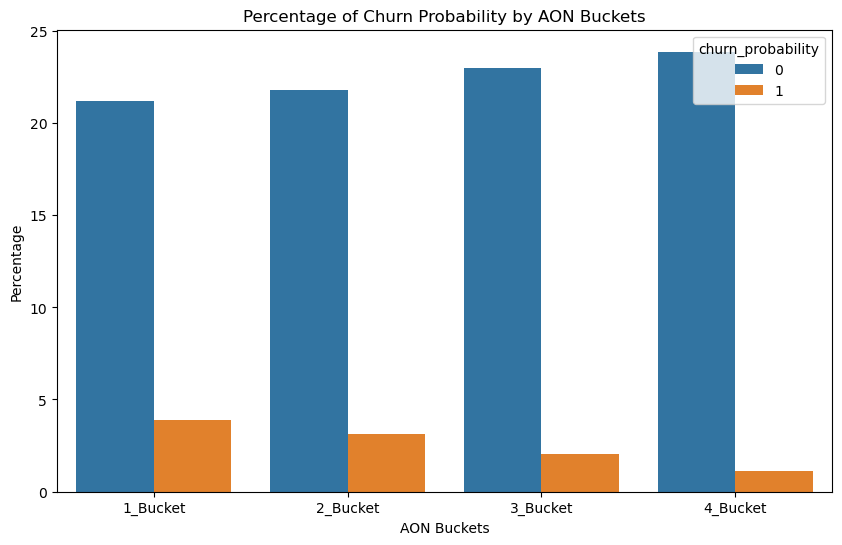

In [68]:
grouped_df = eda_df.groupby(['churn_probability', 'aon_buckets']).count()['aon'] / eda_df.shape[0] * 100
aon_percentage_df = grouped_df.reset_index(name='percentage')

plt.figure(figsize=(10, 6))
sns.barplot(x='aon_buckets', y='percentage', hue='churn_probability', data=aon_percentage_df)
plt.xlabel('AON Buckets')
plt.ylabel('Percentage')
plt.title('Percentage of Churn Probability by AON Buckets')
plt.show()

-We can see that with the more number of time on the network the less change of churn

In [69]:
eda_df['ic_roaming_usage_buckets'] = eda_df['total_incoming_roaming_min_usage'].apply(lambda x : "Below75Q" if x <= 4.0 else "Above75Q")

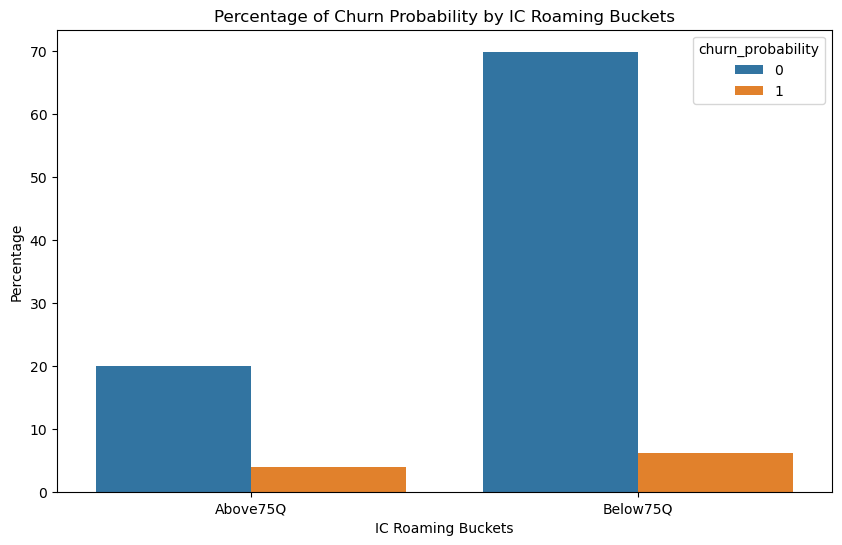

In [70]:
grouped_df_ic_roaming_usage = eda_df.groupby(['churn_probability', 'ic_roaming_usage_buckets']).count()['total_incoming_roaming_min_usage'] / eda_df.shape[0] * 100
ic_roaming_usage_percentage_df = grouped_df_ic_roaming_usage.reset_index(name='percentage')

plt.figure(figsize=(10, 6))
sns.barplot(x='ic_roaming_usage_buckets', y='percentage', hue='churn_probability', data=ic_roaming_usage_percentage_df)
plt.xlabel('IC Roaming Buckets')
plt.ylabel('Percentage')
plt.title('Percentage of Churn Probability by IC Roaming Buckets')
plt.show()

- We can clearly see that below 75th Quartile in our dataset there are most number of people who have not churned but also we need to understand there is a bias in the data as well.

In [71]:
eda_df['og_roaming_usage_buckets'] = eda_df['total_outgoing_roaming_min_usage'].apply(lambda x : "Below75Q" if x <= 4.0 else "Above75Q")

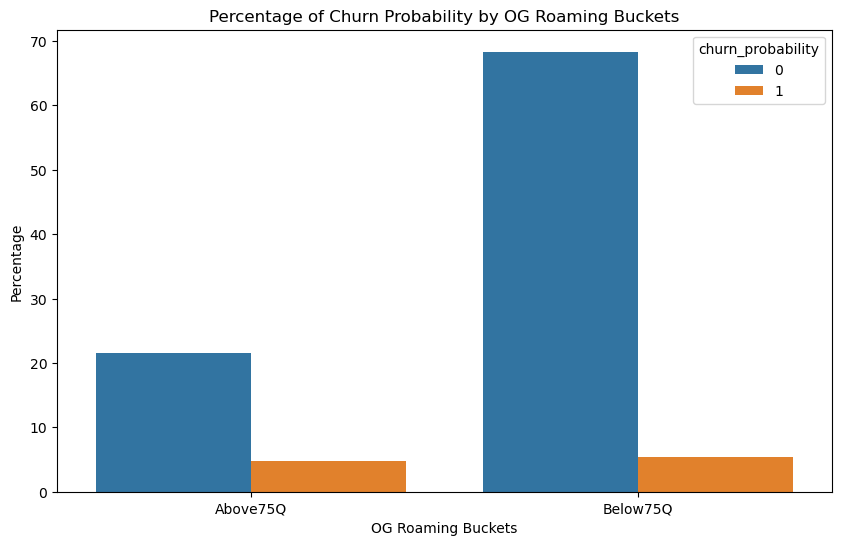

In [72]:
grouped_df_og_roaming_usage = eda_df.groupby(['churn_probability', 'og_roaming_usage_buckets']).count()['total_outgoing_roaming_min_usage'] / eda_df.shape[0] * 100
og_roaming_usage_percentage_df = grouped_df_og_roaming_usage.reset_index(name='percentage')

plt.figure(figsize=(10, 6))
sns.barplot(x='og_roaming_usage_buckets', y='percentage', hue='churn_probability', data=og_roaming_usage_percentage_df)
plt.xlabel('OG Roaming Buckets')
plt.ylabel('Percentage')
plt.title('Percentage of Churn Probability by OG Roaming Buckets')
plt.show()

-We can see that as similar to incoming roaming usage the same is the case with outgoing roaming usage.

In [73]:
eda_df['same_network_call_usage_buckets'] = pd.qcut(eda_df['same_network_calls_min_usage'],q=4,labels=["1_Bucket","2_Bucket","3_Bucket","4_Bucket"])

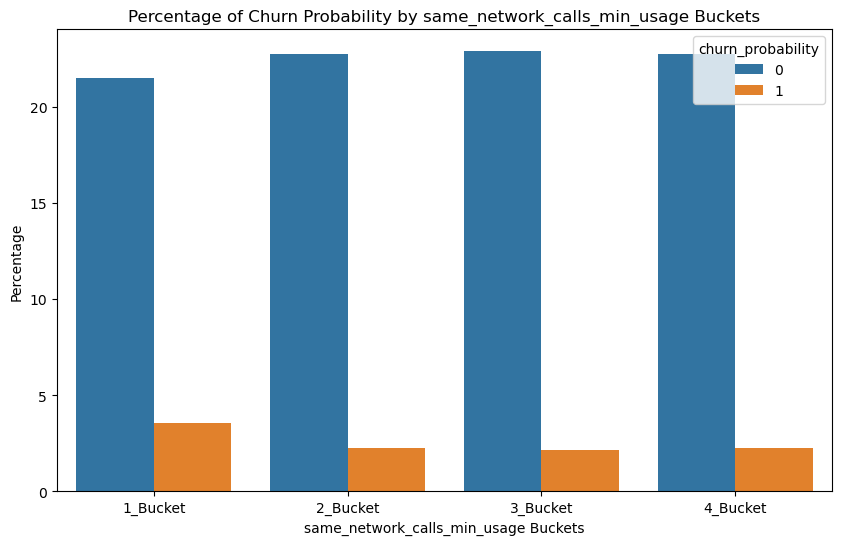

In [74]:
grouped_df = eda_df.groupby(['churn_probability', 'same_network_call_usage_buckets']).count()['same_network_calls_min_usage'] / eda_df.shape[0] * 100
same_network_calls_min_usage_percentage_df = grouped_df.reset_index(name='percentage')

plt.figure(figsize=(10, 6))
sns.barplot(x='same_network_call_usage_buckets', y='percentage', hue='churn_probability', data=same_network_calls_min_usage_percentage_df)
plt.xlabel('same_network_calls_min_usage Buckets')
plt.ylabel('Percentage')
plt.title('Percentage of Churn Probability by same_network_calls_min_usage Buckets')
plt.show()

In [75]:
eda_df['other_network_call_usage_buckets'] = pd.qcut(eda_df['other_network_calls_min_usage'],q=4,labels=["1_Bucket","2_Bucket","3_Bucket","4_Bucket"])

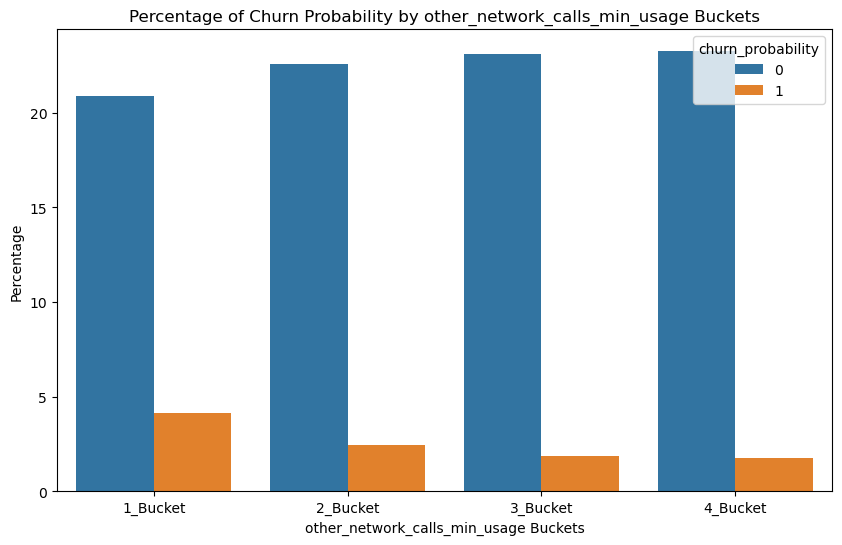

In [76]:
grouped_df = eda_df.groupby(['churn_probability', 'other_network_call_usage_buckets']).count()['other_network_calls_min_usage'] / eda_df.shape[0] * 100
other_network_calls_min_usage_percentage_df = grouped_df.reset_index(name='percentage')

plt.figure(figsize=(10, 6))
sns.barplot(x='other_network_call_usage_buckets', y='percentage', hue='churn_probability', data=other_network_calls_min_usage_percentage_df)
plt.xlabel('other_network_calls_min_usage Buckets')
plt.ylabel('Percentage')
plt.title('Percentage of Churn Probability by other_network_calls_min_usage Buckets')
plt.show()

In [77]:
eda_df['total_rech_amount_buckets'] = pd.qcut(eda_df['total_rech_amount'],q=4,labels=["1_Bucket","2_Bucket","3_Bucket","4_Bucket"])

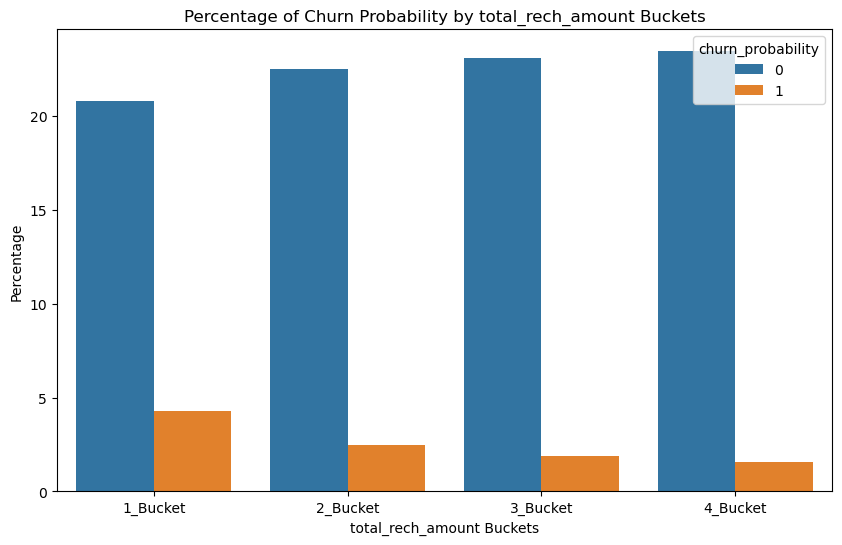

In [78]:
grouped_df = eda_df.groupby(['churn_probability', 'total_rech_amount_buckets']).count()['total_rech_amount'] / eda_df.shape[0] * 100
total_rech_amount_percentage_df = grouped_df.reset_index(name='percentage')

plt.figure(figsize=(10, 6))
sns.barplot(x='total_rech_amount_buckets', y='percentage', hue='churn_probability', data=total_rech_amount_percentage_df)
plt.xlabel('total_rech_amount Buckets')
plt.ylabel('Percentage')
plt.title('Percentage of Churn Probability by total_rech_amount Buckets')
plt.show()

In [79]:
eda_df['churn_probability'] = eda_df['churn_probability'].map({"No_Churn":0,"Churn":1})

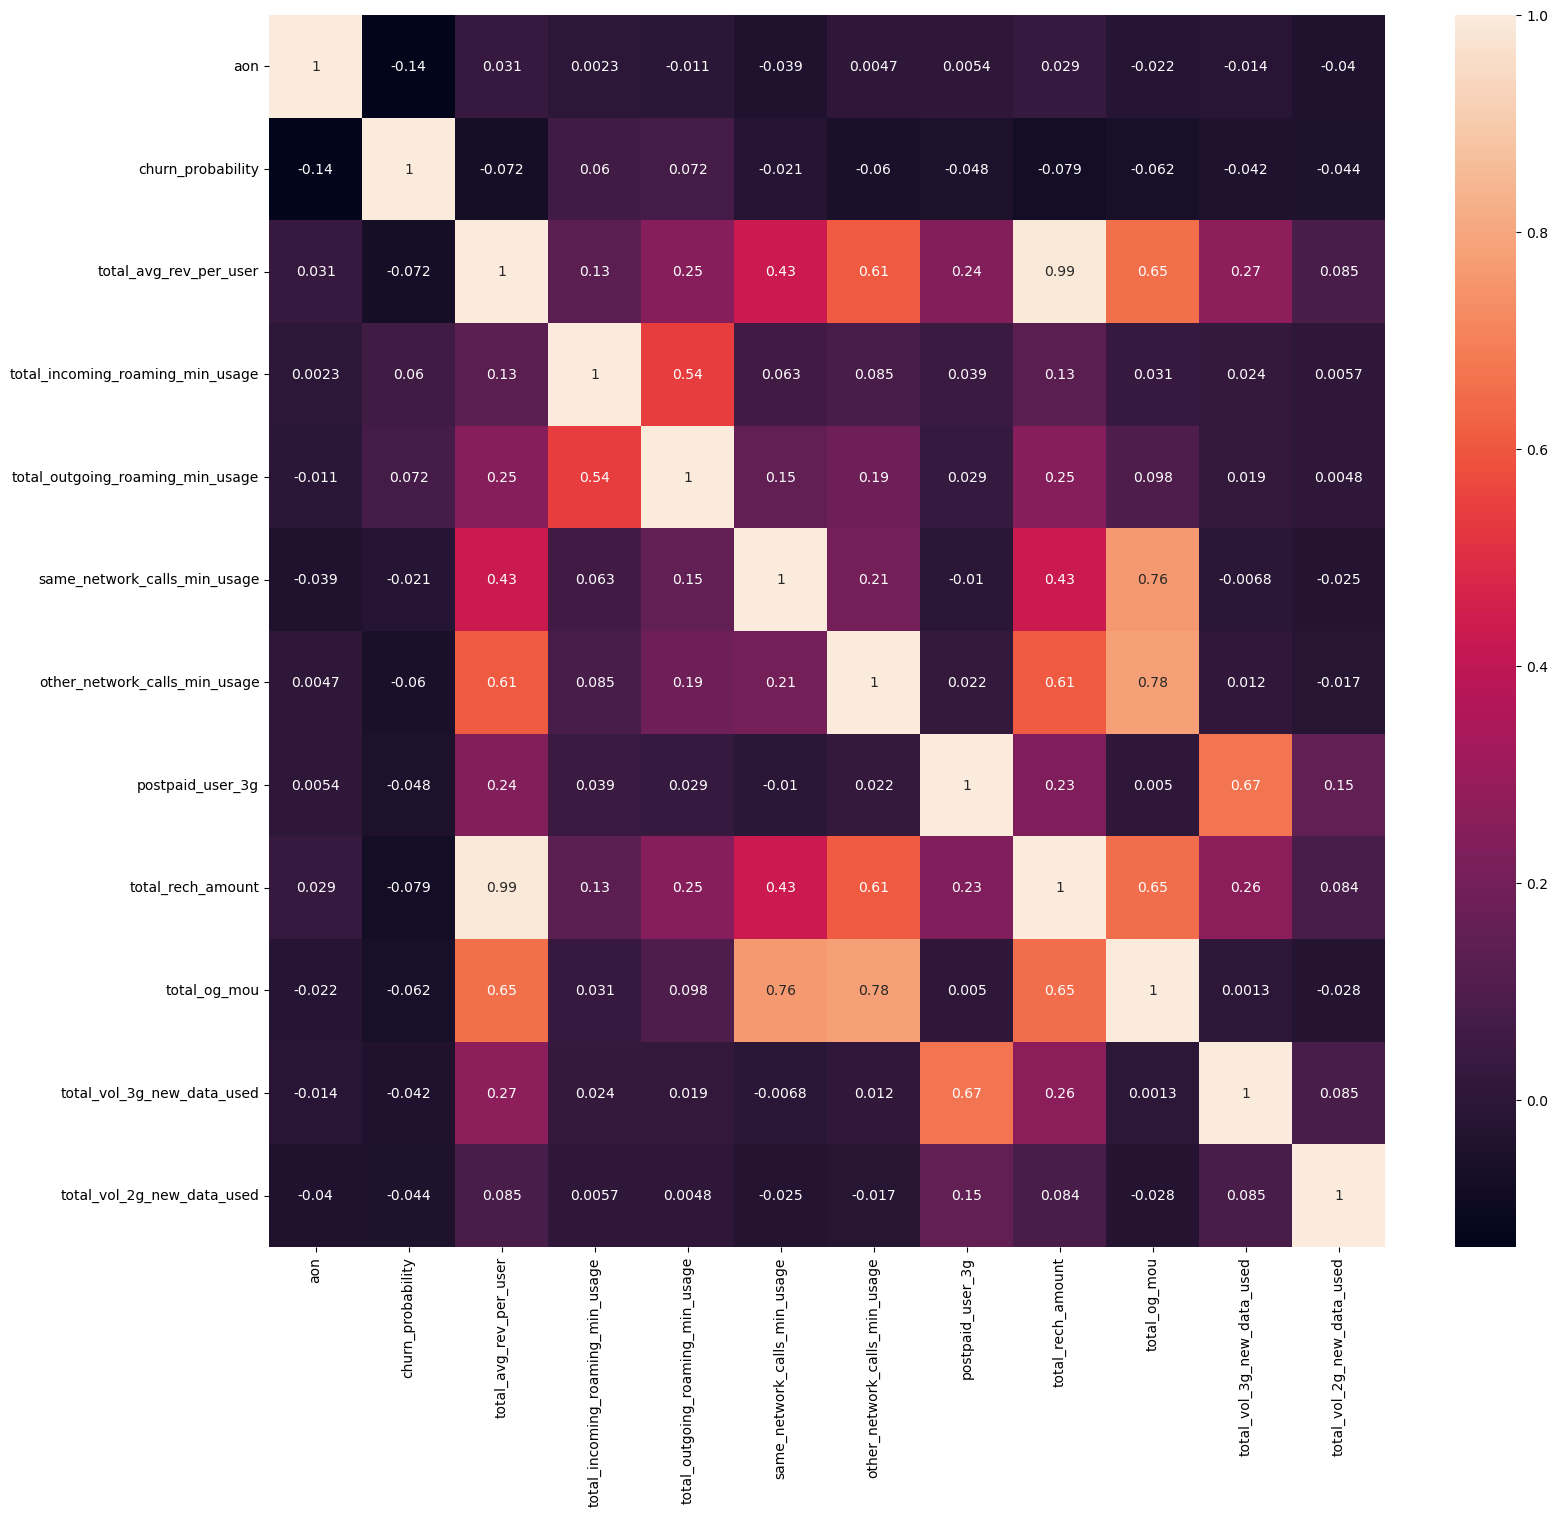

In [80]:
plt.figure(figsize=(18,16))
sns.heatmap(new_data.corr(),annot=True)
plt.show()

## Preprocessing and Training 

In [81]:
X = df_train.drop(['churn_probability'],axis=1)
y=df_train['churn_probability']

In [82]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=1)

In [83]:
scaler = StandardScaler()

In [84]:
normalized_x_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)

In [85]:
normalized_x_train.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,-0.516727,-0.348658,-0.322476,-0.394081,-0.328411,-0.256004,-0.242954,-0.069247,0.124722,-0.16653,...,-0.211829,-0.202658,-0.21126,-0.129025,-0.128343,-0.124488,1.447769,-0.253135,-0.249159,-0.229571
1,-0.282979,-0.148382,-0.173348,-0.192327,-0.294101,-0.189666,-0.211546,0.104213,-0.039724,-0.16653,...,-0.211829,-0.202658,-0.21126,-0.129025,-0.128343,-0.124488,-0.512013,-0.253135,-0.249159,-0.229571
2,-0.420041,-0.105758,0.065586,-0.237259,-0.190617,0.040143,-0.274551,0.117886,0.209770,-0.16653,...,-0.211829,-0.202658,-0.21126,-0.129025,-0.128343,-0.124488,0.128644,-0.253135,-0.249159,-0.229571
3,0.547193,0.767860,0.924520,-0.155482,-0.224665,0.125439,1.321837,1.619264,1.915850,-0.16653,...,-0.211829,-0.202658,-0.21126,-0.129025,-0.128343,-0.124488,1.643117,-0.253135,-0.249159,-0.229571
4,-0.756466,-0.647949,-0.578615,-0.389784,-0.419609,-0.405947,-0.579037,-0.499228,-0.429890,-0.16653,...,-0.211829,-0.202658,-0.21126,-0.129025,-0.128343,-0.124488,-0.429043,-0.253135,-0.249159,-0.229571


In [86]:
normalized_x_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

In [87]:
def confusion_matrix_plot(matrix=None,classes=None,name='Logistic Regression'):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('img1.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels',fontsize = 15,fontweight = 3);
    ax.set_ylabel('True labels',fontsize = 15,fontweight = 3); 
    ax.set_title('Confusion Matrix of '+name,fontsize = 25,fontweight = 5); 
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

In [88]:
def cal_score(x_test=None,y_test=None,model=None,name=None):
    predictions = model.predict(x_test)
    labels=y_test
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    classes=[False,True]
    print(classification_report(predictions, labels, labels=classes))
    
    confusion_matrix_plot(matrix = matrix,classes = classes,name = name)

### TRYING DIFFERENT MODELS

- LOG REG

[[18583  1620]
 [  241   556]]


F1 Score: 0.9303678813504356


              precision    recall  f1-score   support

       False       0.99      0.92      0.95     20203
        True       0.26      0.70      0.37       797

    accuracy                           0.91     21000
   macro avg       0.62      0.81      0.66     21000
weighted avg       0.96      0.91      0.93     21000



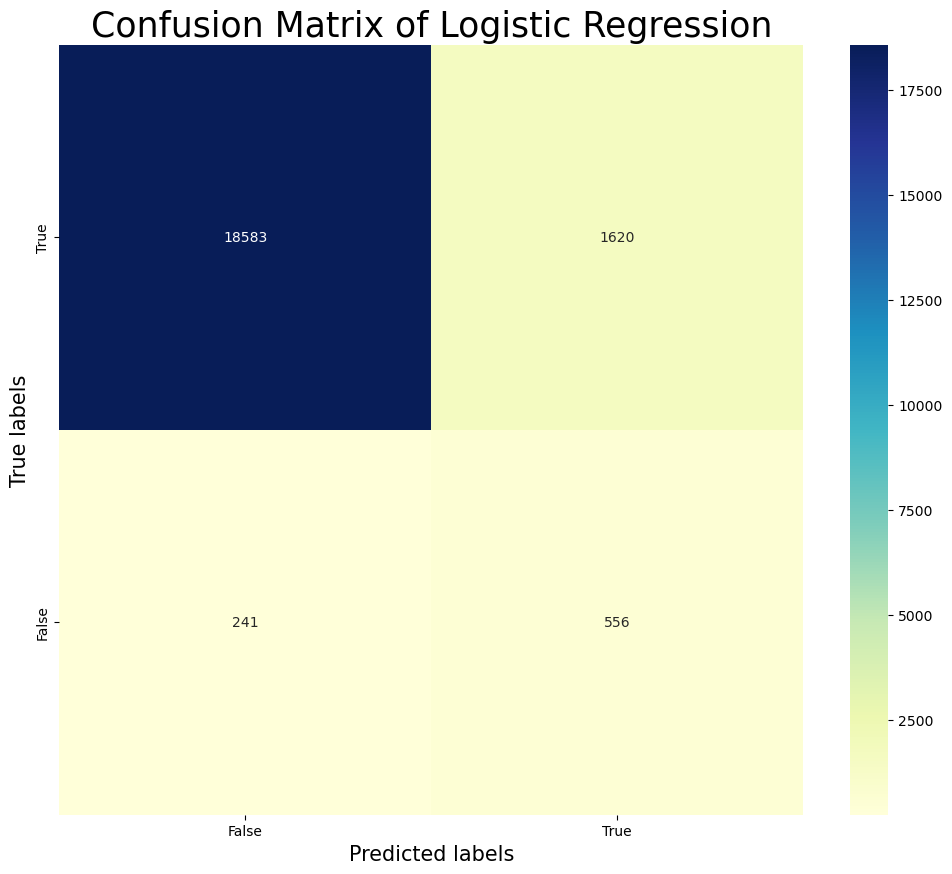

In [89]:
lr = LogisticRegression(max_iter=10000)
lr.fit(normalized_x_train,y_train)
cal_score(x_test=normalized_x_test,y_test=y_test,model=lr,name='Logistic Regression')

- DECISION TREE

[[17790   959]
 [ 1034  1217]]


F1 Score: 0.904386044175982


              precision    recall  f1-score   support

       False       0.95      0.95      0.95     18749
        True       0.56      0.54      0.55      2251

    accuracy                           0.91     21000
   macro avg       0.75      0.74      0.75     21000
weighted avg       0.90      0.91      0.90     21000



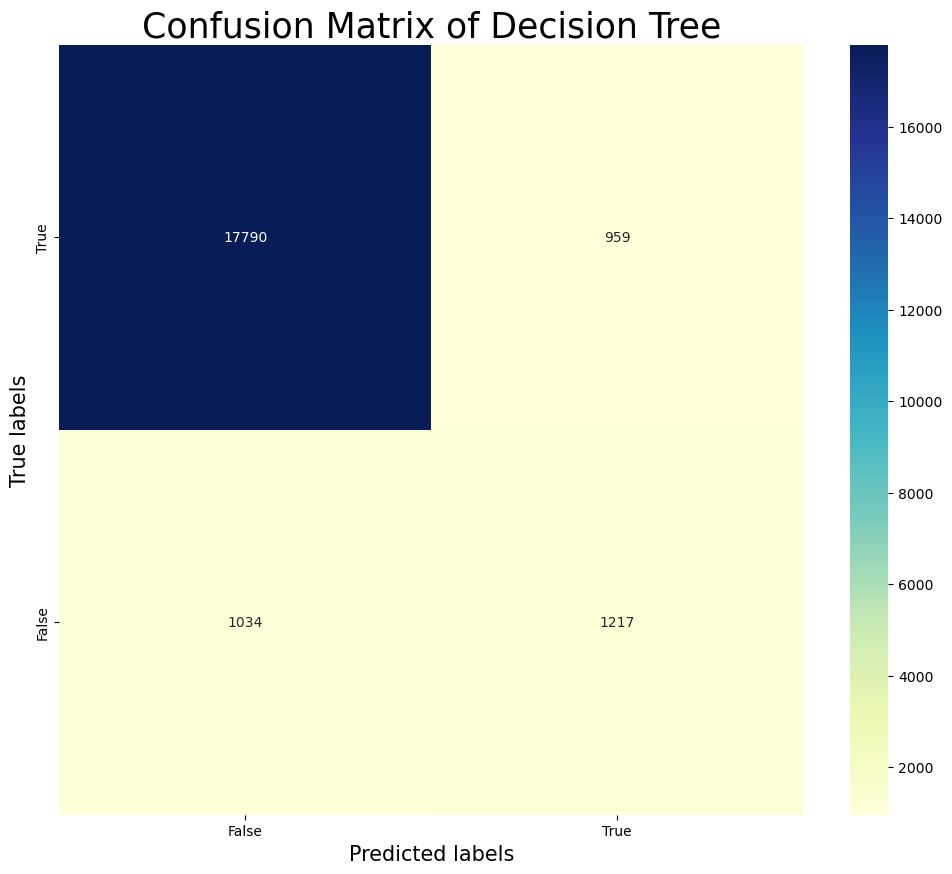

In [90]:
dr = DecisionTreeClassifier()
dr.fit(normalized_x_train,y_train)
cal_score(x_test=normalized_x_test,y_test=y_test,model=dr,name='Decision Tree')

- RANDOM FOREST

[[18450   896]
 [  374  1280]]


F1 Score: 0.9432315069925925


              precision    recall  f1-score   support

       False       0.98      0.95      0.97     19346
        True       0.59      0.77      0.67      1654

    accuracy                           0.94     21000
   macro avg       0.78      0.86      0.82     21000
weighted avg       0.95      0.94      0.94     21000



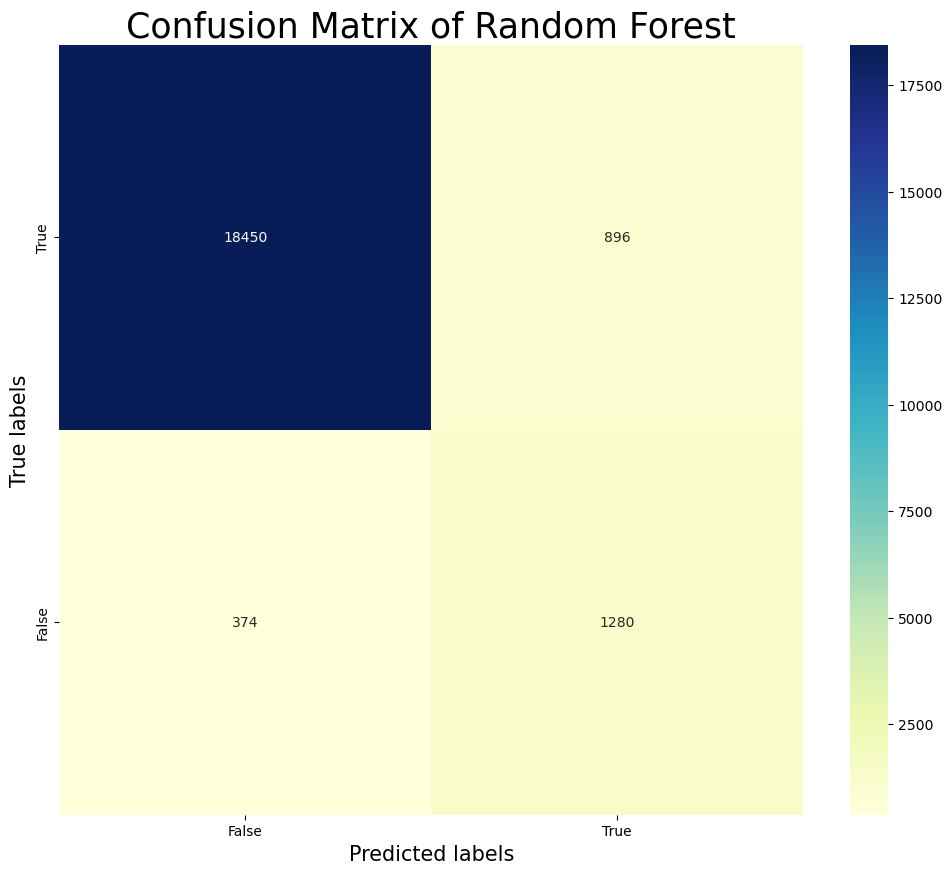

In [91]:
rf = RandomForestClassifier()
rf.fit(normalized_x_train,y_train)
cal_score(x_test=normalized_x_test,y_test=y_test,model=rf,name='Random Forest')

- XGBOOST

In [92]:
# # Define parameter grid
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'n_estimators': [100, 300, 500]
# }

# xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# # we want to target a better f1 score due to imbalance in data
# f1_scorer = make_scorer(f1_score, average='weighted')
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
#                            scoring=f1_scorer, cv=5, n_jobs=-1)

# # Fit the model
# grid_search.fit(normalized_x_train, y_train)

# # Best parameters and score
# print("Best parameters:", grid_search.best_params_)
# print("Best F1 score:", grid_search.best_score_)

c:\Users\AnkitSukantaKumarGay\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:15:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[18382   780]
 [  442  1396]]


F1 Score: 0.9440006066573778


              precision    recall  f1-score   support

       False       0.98      0.96      0.97     19162
        True       0.64      0.76      0.70      1838

    accuracy                           0.94     21000
   macro avg       0.81      0.86      0.83     21000
weighted avg       0.95      0.94      0.94     21000



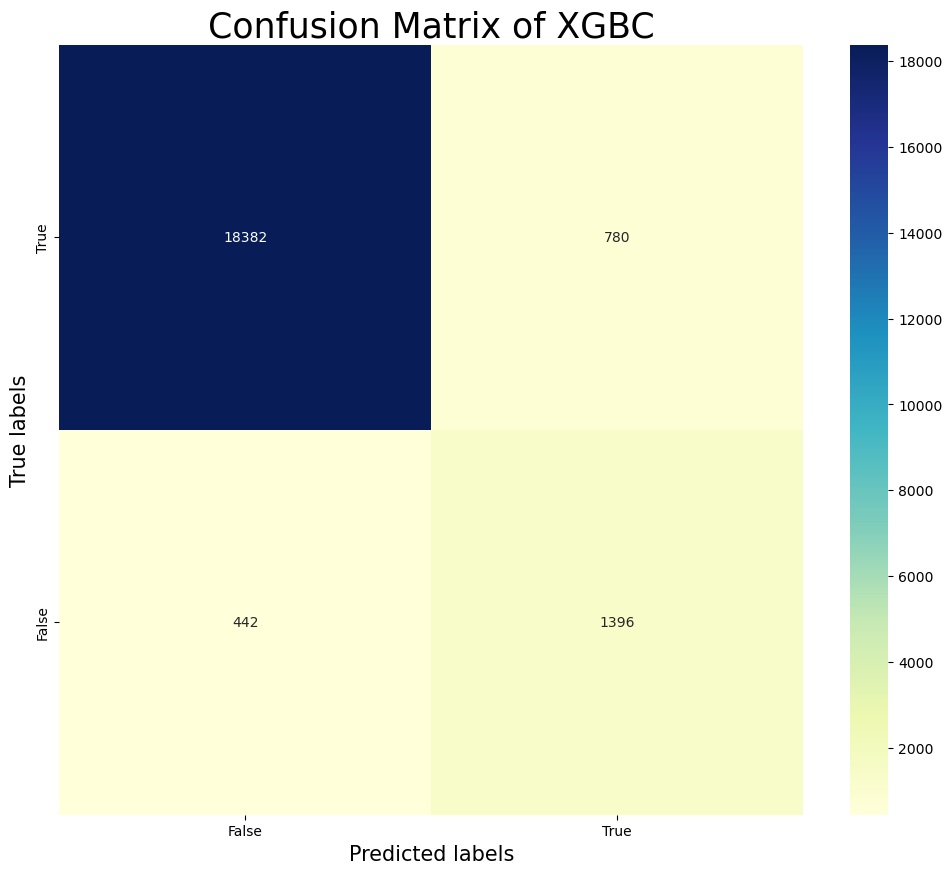

In [94]:
xgbc = XGBClassifier(
    colsample_bytree=0.6,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    n_estimators=300,
    subsample=1.0,
    use_label_encoder=False,  # Necessary for newer versions of XGBoost
    eval_metric='logloss'     # Specify an evaluation metric
)

xgbc.fit(normalized_x_train,y_train)
cal_score(x_test=normalized_x_test,y_test=y_test,model=xgbc,name='XGBC')

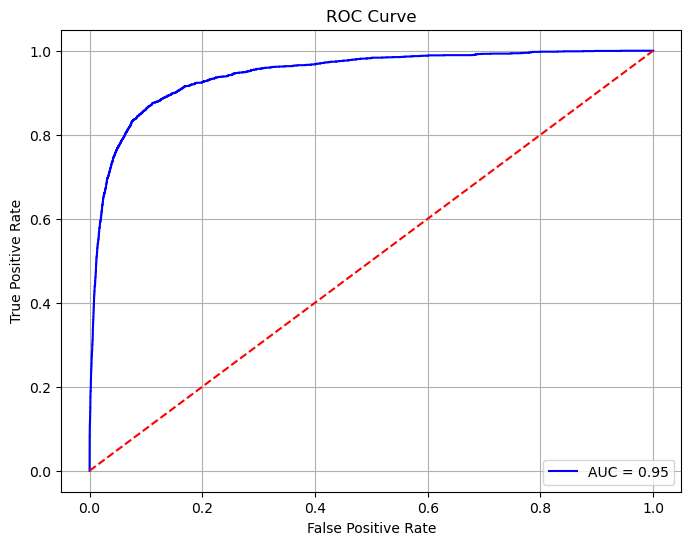

In [95]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for the test set
y_pred_proba = xgbc.predict_proba(normalized_x_test)[:, 1]  # Get probabilities for the positive class

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [96]:
pd.DataFrame({
    'Feature': normalized_x_train.columns,
    'Importance': xgbc.feature_importances_
}).sort_values(by='Importance', ascending=False)


,Feature,Importance
80,total_ic_mou_8,0.223027
65,loc_ic_mou_8,0.119017
29,loc_og_mou_8,0.110175
59,loc_ic_t2m_mou_8,0.095013
14,roam_og_mou_8,0.020579
...,...,...
121,aug_vbc_3g,0.001035
50,og_others_8,0.000000
49,og_others_7,0.000000
118,sachet_3g_7,0.000000


## Submission File

In [97]:
df_test = pd.read_csv('test.csv')

In [98]:
output = pd.DataFrame()

In [99]:
output['id'] = df_test['id']

In [100]:
df_test = df_test[X.columns]

In [101]:
percent_null = df_test.isnull().sum().sum() / np.product(df_test.shape) * 100
percent_null

2.9148387096774195

In [102]:
for col in df_test.columns:
    null_col = df_test[col].isnull().sum() / df_test.shape[0] * 100
    print("{} : {:.2f}".format(col,null_col))

arpu_6 : 0.00
arpu_7 : 0.00
arpu_8 : 0.00
onnet_mou_6 : 3.90
onnet_mou_7 : 3.91
onnet_mou_8 : 5.58
offnet_mou_6 : 3.90
offnet_mou_7 : 3.91
offnet_mou_8 : 5.58
roam_ic_mou_6 : 3.90
roam_ic_mou_7 : 3.91
roam_ic_mou_8 : 5.58
roam_og_mou_6 : 3.90
roam_og_mou_7 : 3.91
roam_og_mou_8 : 5.58
loc_og_t2t_mou_6 : 3.90
loc_og_t2t_mou_7 : 3.91
loc_og_t2t_mou_8 : 5.58
loc_og_t2m_mou_6 : 3.90
loc_og_t2m_mou_7 : 3.91
loc_og_t2m_mou_8 : 5.58
loc_og_t2f_mou_6 : 3.90
loc_og_t2f_mou_7 : 3.91
loc_og_t2f_mou_8 : 5.58
loc_og_t2c_mou_6 : 3.90
loc_og_t2c_mou_7 : 3.91
loc_og_t2c_mou_8 : 5.58
loc_og_mou_6 : 3.90
loc_og_mou_7 : 3.91
loc_og_mou_8 : 5.58
std_og_t2t_mou_6 : 3.90
std_og_t2t_mou_7 : 3.91
std_og_t2t_mou_8 : 5.58
std_og_t2m_mou_6 : 3.90
std_og_t2m_mou_7 : 3.91
std_og_t2m_mou_8 : 5.58
std_og_t2f_mou_6 : 3.90
std_og_t2f_mou_7 : 3.91
std_og_t2f_mou_8 : 5.58
std_og_mou_6 : 3.90
std_og_mou_7 : 3.91
std_og_mou_8 : 5.58
isd_og_mou_6 : 3.90
isd_og_mou_7 : 3.91
isd_og_mou_8 : 5.58
spl_og_mou_6 : 3.90
spl_og_mou_

In [103]:
df_test['jun_vbc_3g'].mode()[0]

0.0

In [104]:
for col in df_test.columns:
    null_col = df_test[col].isnull().sum() / df_test.shape[0] * 100
    if null_col > 0:
        df_test[col] = df_test[col].fillna(df_test[col].mode()[0])

In [105]:
df_test.isnull().sum().sum()

0

In [106]:
final_normalized_x_test = pd.DataFrame(scaler.transform(df_test),columns = df_test.columns)

In [107]:
output['churn_probability'] = rf.predict(final_normalized_x_test)

In [108]:
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0


In [109]:
output.to_csv('submission_file.csv',index=False)